In [143]:
# import libraries
import warnings
import pandas as pd
import numpy as np
from numpy import mean, std
import seaborn as sns
import plotly.express as px
from scipy.io.arff import loadarff
from matplotlib import pyplot as plt
from datetime import datetime as dt
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, learning_curve
#from mlxtend.evaluate import bias_variance_decomp
warnings.filterwarnings('ignore')

In [5]:
# load dataset
df = pd.read_csv('./data.csv')
df.head()
df.head()

,id,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,21.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Data Preparation

### Build the data quality report

In [6]:
# Data Type Normalization
df = df.convert_dtypes()
# General infomation
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    Int64  
 1   diagnosis                569 non-null    string 
 2   Radius_mean              569 non-null    Float64
 3   Texture_mean             569 non-null    Float64
 4   perimeter_mean           569 non-null    Float64
 5   area_mean                569 non-null    Float64
 6   smoothness_mean          569 non-null    Float64
 7   compactness_mean         569 non-null    Float64
 8   concavity_mean           569 non-null    Float64
 9   concave points_mean      569 non-null    Float64
 10  symmetry_mean            569 non-null    Float64
 11  fractal_dimension_mean   569 non-null    Float64
 12  radius_se                569 non-null    Float64
 13  texture_se               569 non-null    Float64
 14  perimeter_se             5

#### Continous feature report

In [7]:
def build_continuous_features_report(data_df):
    
    """Build tabular report for continuous features"""

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Min": lambda df: df.min(),
        "1st Qrt.": lambda df: df.quantile(0.25),
        "Mean": lambda df: df.mean(),
        "Median": lambda df: df.median(),
        "3rd Qrt": lambda df: df.quantile(0.75),
        "Max": lambda df: df.max(),
        "Std. Dev.": lambda df: df.std(),
    }

    contin_feat_names = data_df.select_dtypes("number").columns
    continuous_data_df = data_df[contin_feat_names]

    report_df = pd.DataFrame(index=contin_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df

    # generate the continuous data quility report
build_continuous_features_report(df.iloc[:,1:])

,Count,Miss %,Card.,Min,1st Qrt.,Mean,Median,3rd Qrt,Max,Std. Dev.
Radius_mean,569,0.0,456,6.981000,11.7,14.127292,13.370000,15.78,28.11000,3.524049
Texture_mean,569,0.0,479,9.710000,16.17,19.296678,18.870000,21.8,39.28000,4.301816
perimeter_mean,569,0.0,522,43.790000,75.17,91.969033,86.240000,104.1,188.50000,24.298981
area_mean,569,0.0,539,143.500000,420.3,654.889104,551.100000,782.7,2501.00000,351.914129
smoothness_mean,569,0.0,474,0.052630,0.08637,0.096360,0.095870,0.1053,0.16340,0.014064
compactness_mean,569,0.0,537,0.019380,0.06492,0.104341,0.092630,0.1304,0.34540,0.052813
concavity_mean,569,0.0,537,0.000000,0.02956,0.088799,0.061540,0.1307,0.42680,0.079720
concave points_mean,569,0.0,542,0.000000,0.02031,0.048919,0.033500,0.074,0.20120,0.038803
symmetry_mean,569,0.0,432,0.106000,0.1619,0.181162,0.179200,0.1957,0.30400,0.027414
fractal_dimension_mean,569,0.0,499,0.049960,0.0577,0.062798,0.061540,0.06612,0.09744,0.007060


In [8]:
# generate the continuous data quility report
df.iloc[:,1:].describe()

,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.296678,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301816,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.870000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


#### Categorical features report

In [9]:
def build_categorical_features_report(data_df):

    """Build tabular report for categorical features"""

    def _mode(df):
        return df.apply(lambda ft: ft.mode().to_list())

    def _mode_freq(df):
        return df.apply(lambda ft: ft.value_counts()[ft.mode()].sum())

    def _second_mode(df):
        return df.apply(lambda ft: ft[~ft.isin(ft.mode())].mode().to_list())

    def _second_mode_freq(df):
        return df.apply(
            lambda ft: ft[~ft.isin(ft.mode())]
            .value_counts()[ft[~ft.isin(ft.mode())].mode()]
            .sum()
        )

    stats = {
        "Count": len,
        "Miss %": lambda df: df.isna().sum() / len(df) * 100,
        "Card.": lambda df: df.nunique(),
        "Mode": _mode,
        "Mode Freq": _mode_freq,
        "Mode %": lambda df: _mode_freq(df) / len(df) * 100,
        "2nd Mode": _second_mode,
        "2nd Mode Freq": _second_mode_freq,
        "2nd Mode %": lambda df: _second_mode_freq(df) / len(df) * 100,
    }

    cat_feat_names = data_df.select_dtypes(exclude="number").columns
    continuous_data_df = data_df[cat_feat_names]

    report_df = pd.DataFrame(index=cat_feat_names, columns=stats.keys())

    for stat_name, fn in stats.items():
        # NOTE: ignore warnings for empty features
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            report_df[stat_name] = fn(continuous_data_df)

    return report_df


# generate the category data quility report
build_categorical_features_report(df)

,Count,Miss %,Card.,Mode,Mode Freq,Mode %,2nd Mode,2nd Mode Freq,2nd Mode %
diagnosis,569,0.0,2,NaN,357,62.741652,NaN,212,37.258348


In [10]:
# generate the category data quility report
df.describe(exclude=['number'])

,diagnosis
count,569
unique,2
top,B
freq,357


#### Feature visualization

##### Continuous feature - Histograms

In [11]:
# Set the figure size - handy for larger output
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["font.size"] = 15

# Set up with a higher resolution screen (useful on Mac)
%config InlineBackend.figure_format = 'retina'

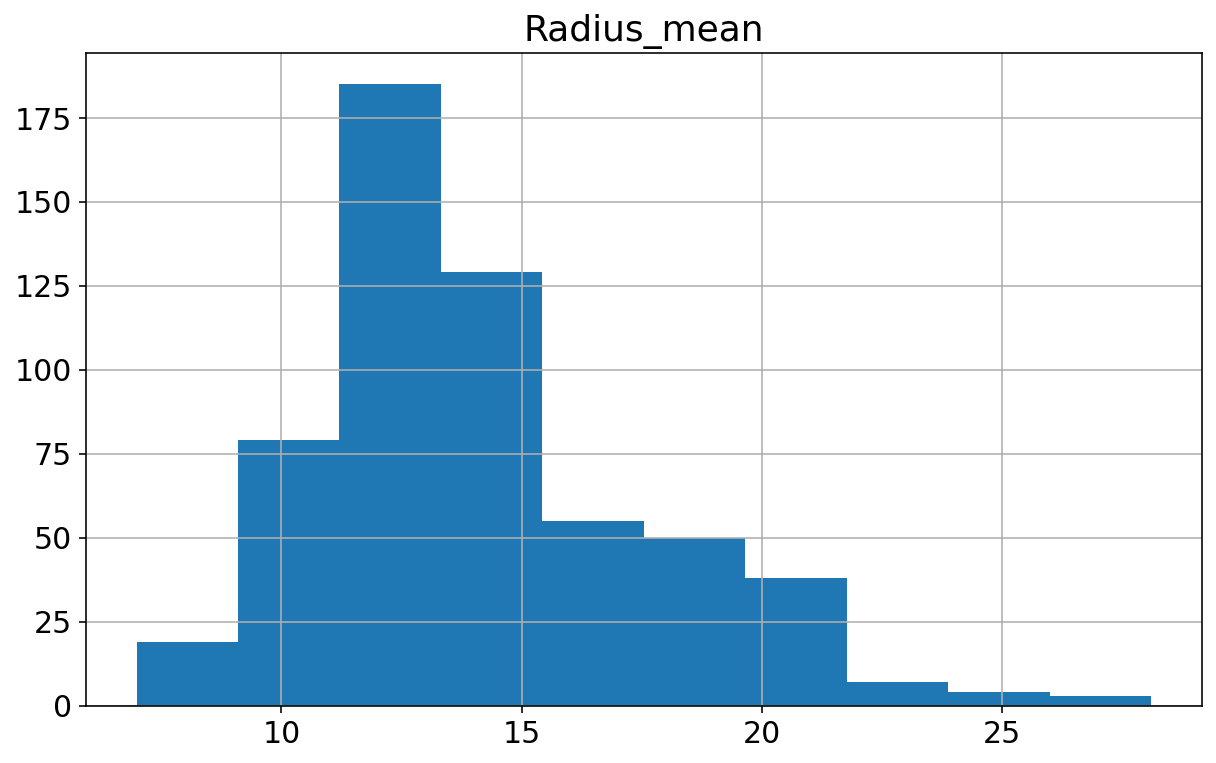

In [12]:
df.hist(column=['Radius_mean']);

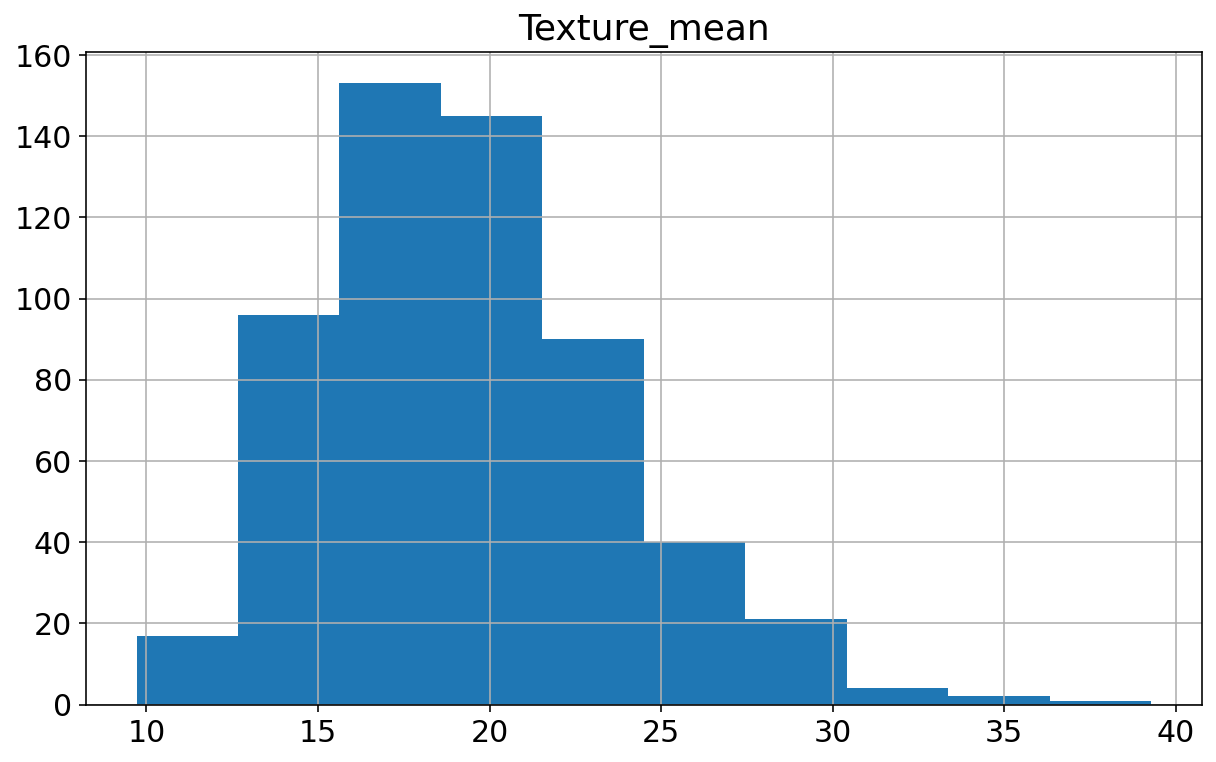

In [13]:
df.hist(column=['Texture_mean']);

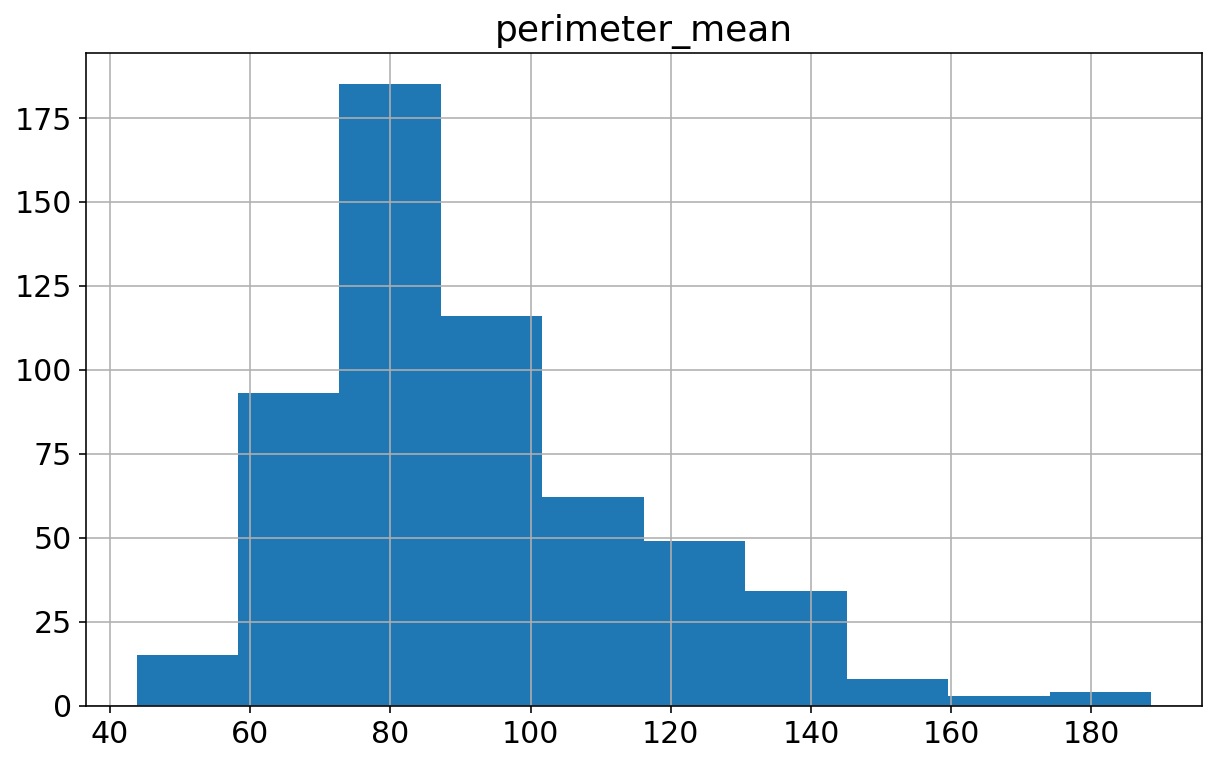

In [14]:
df.hist(column=['perimeter_mean']);

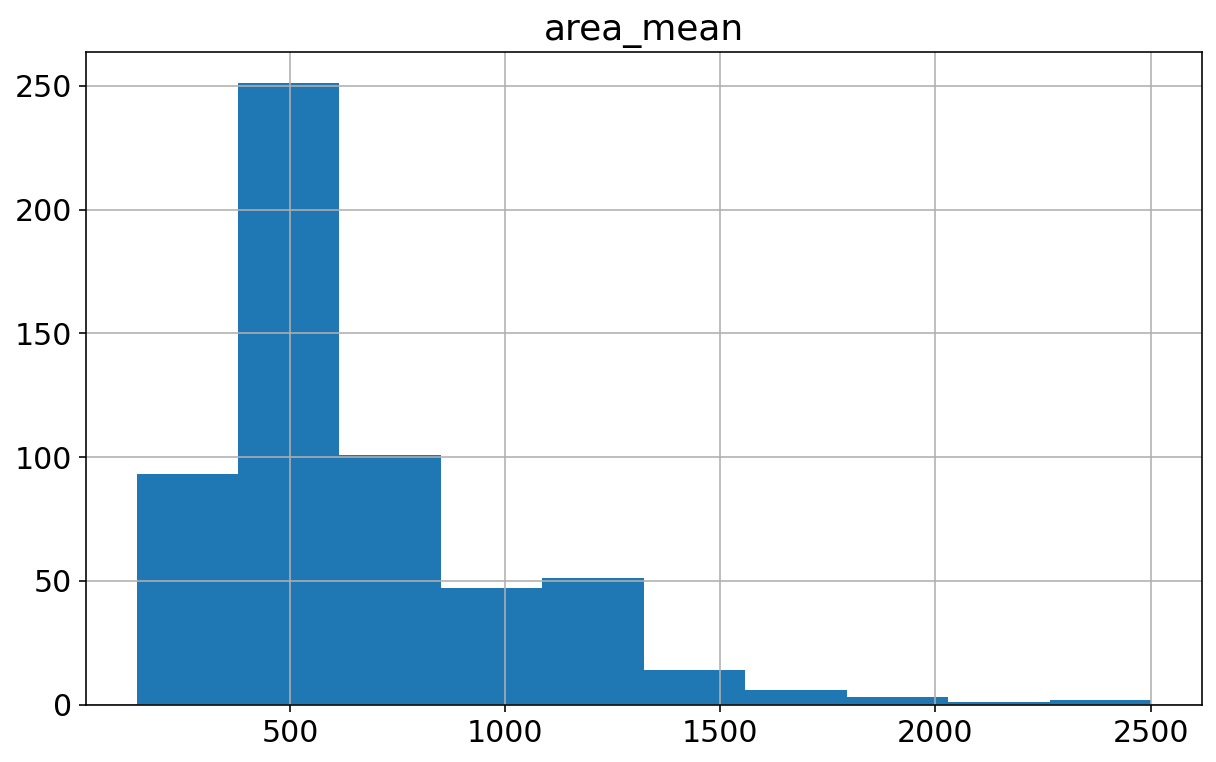

In [15]:
df.hist(column=['area_mean']);

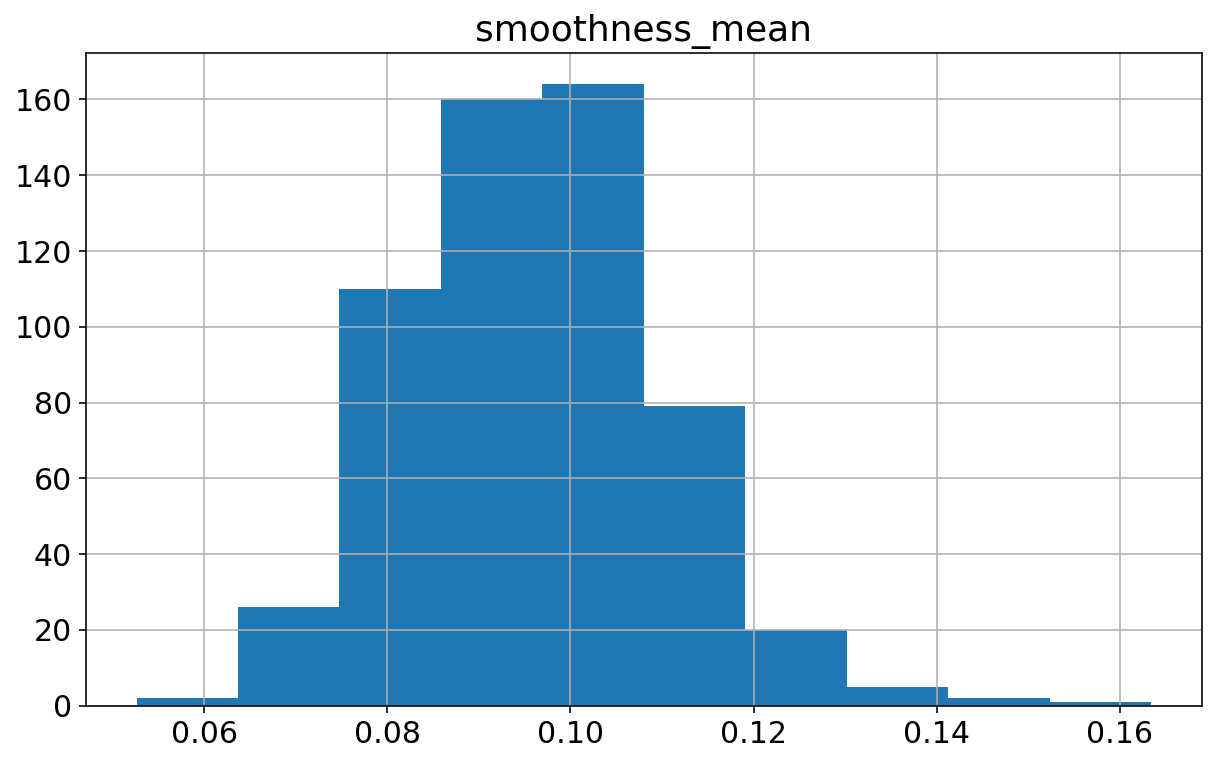

In [16]:
df.hist(column=['smoothness_mean']);

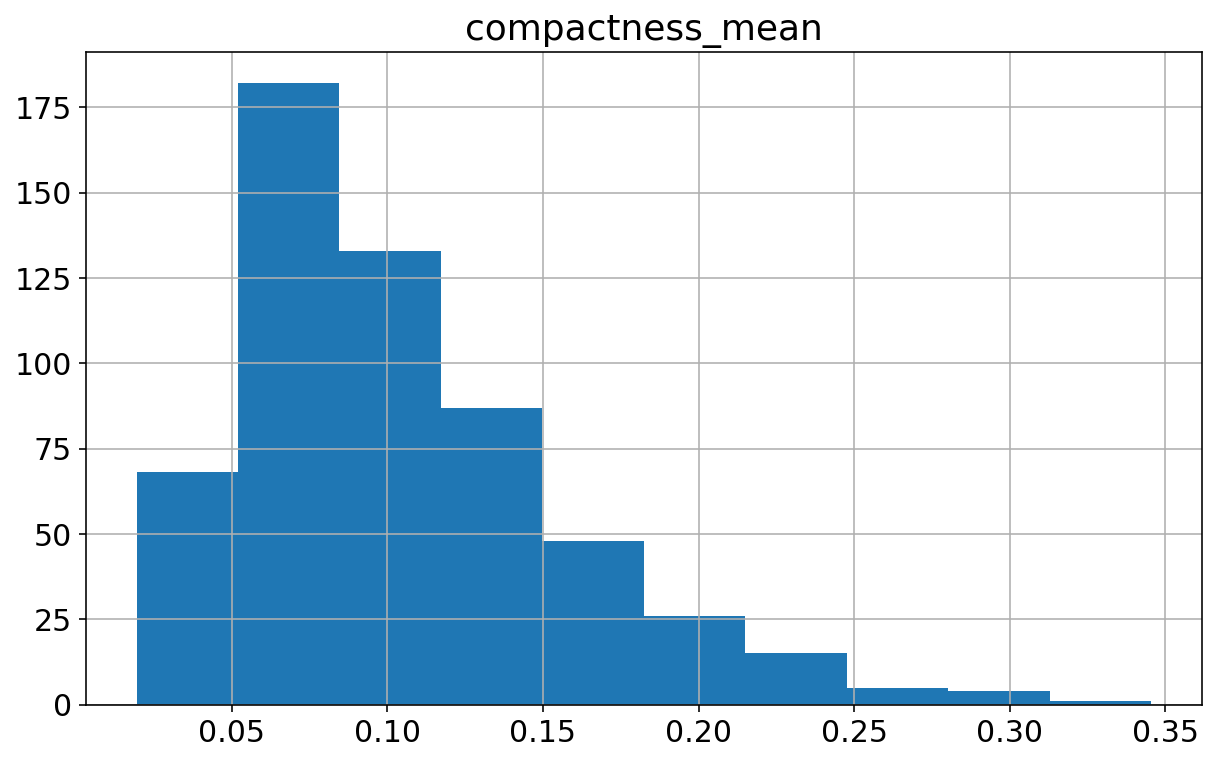

In [17]:
df.hist(column=['compactness_mean']);

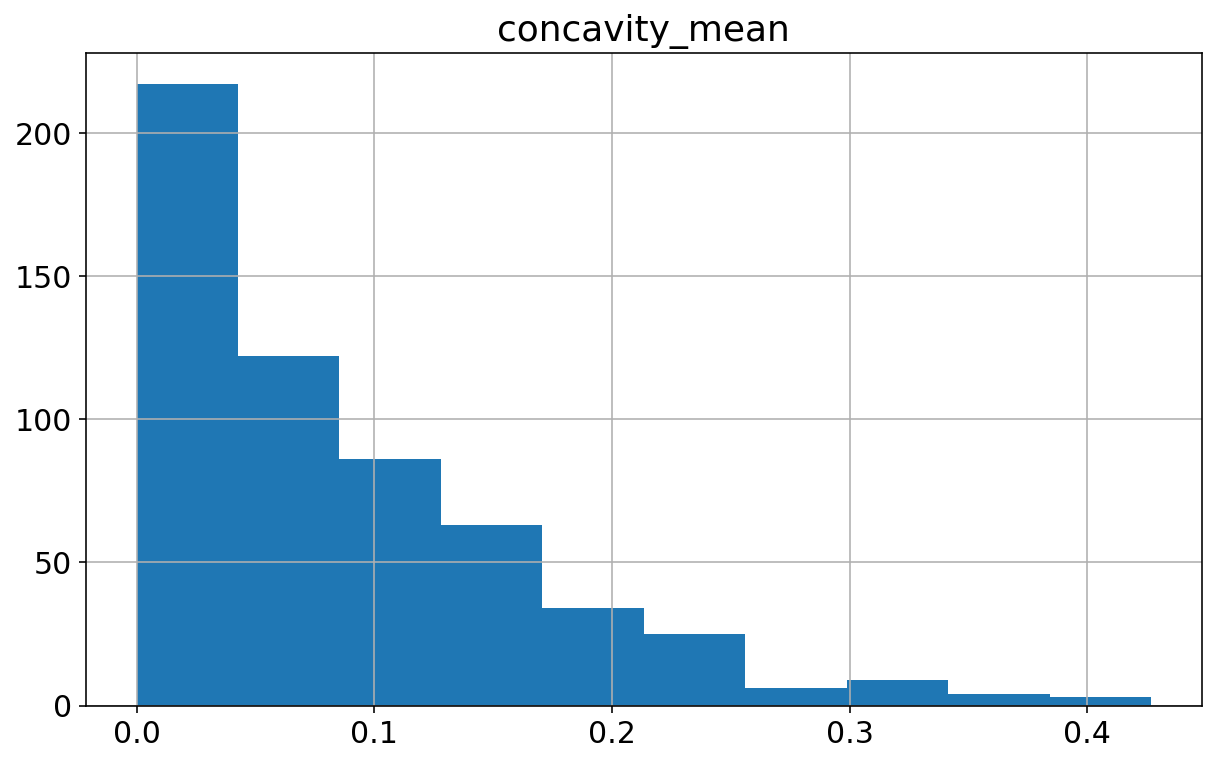

In [18]:
df.hist(column=['concavity_mean']);

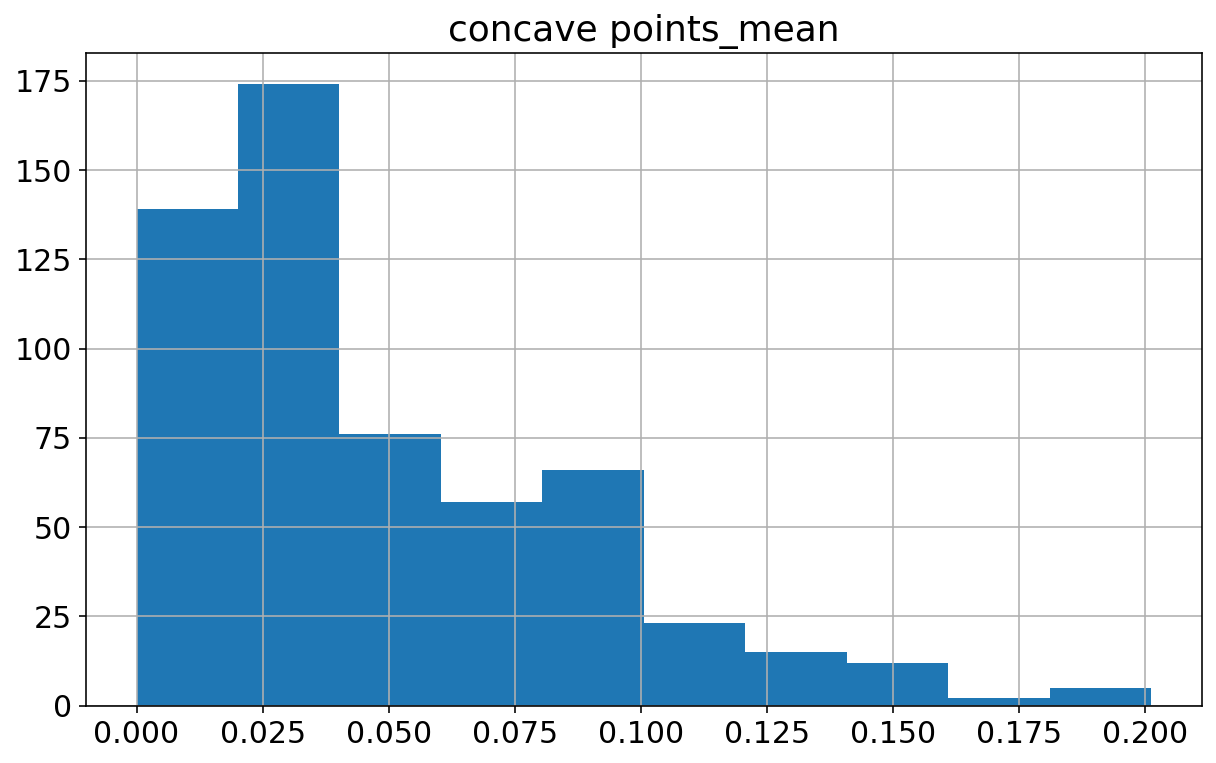

In [19]:
df.hist(column=['concave points_mean']);

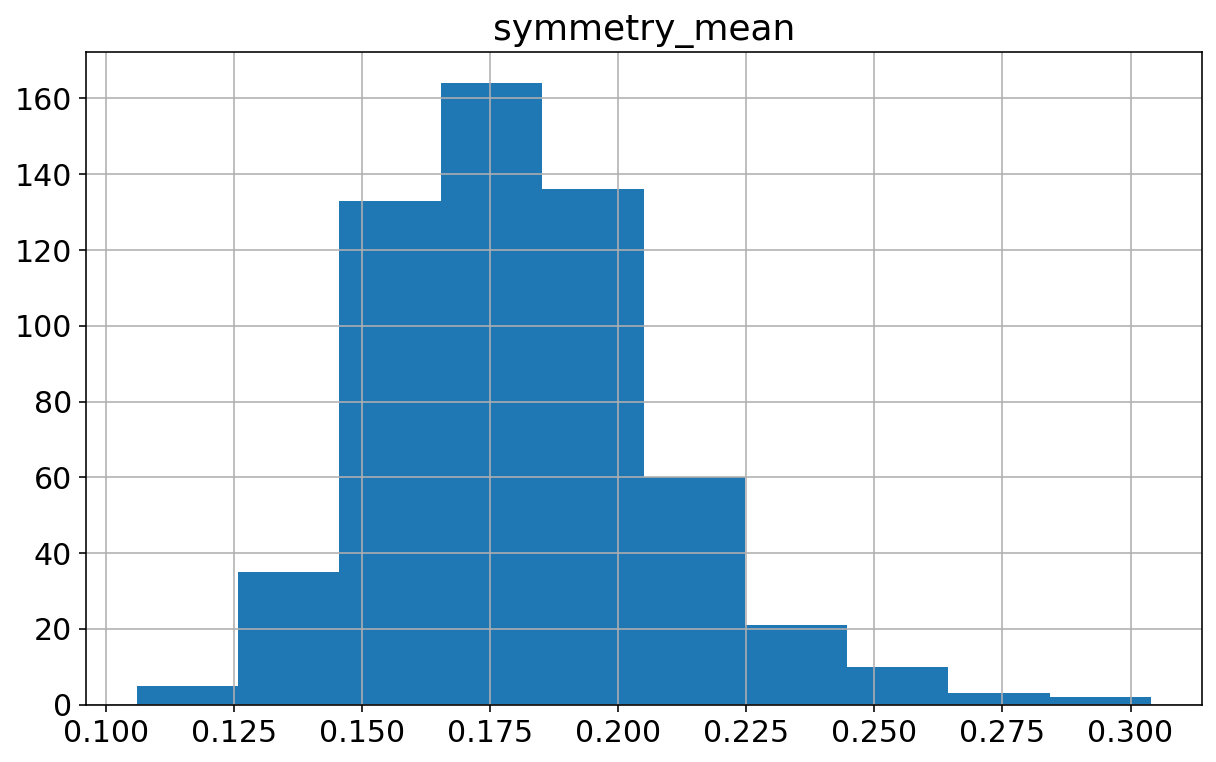

In [20]:
df.hist(column=['symmetry_mean']);

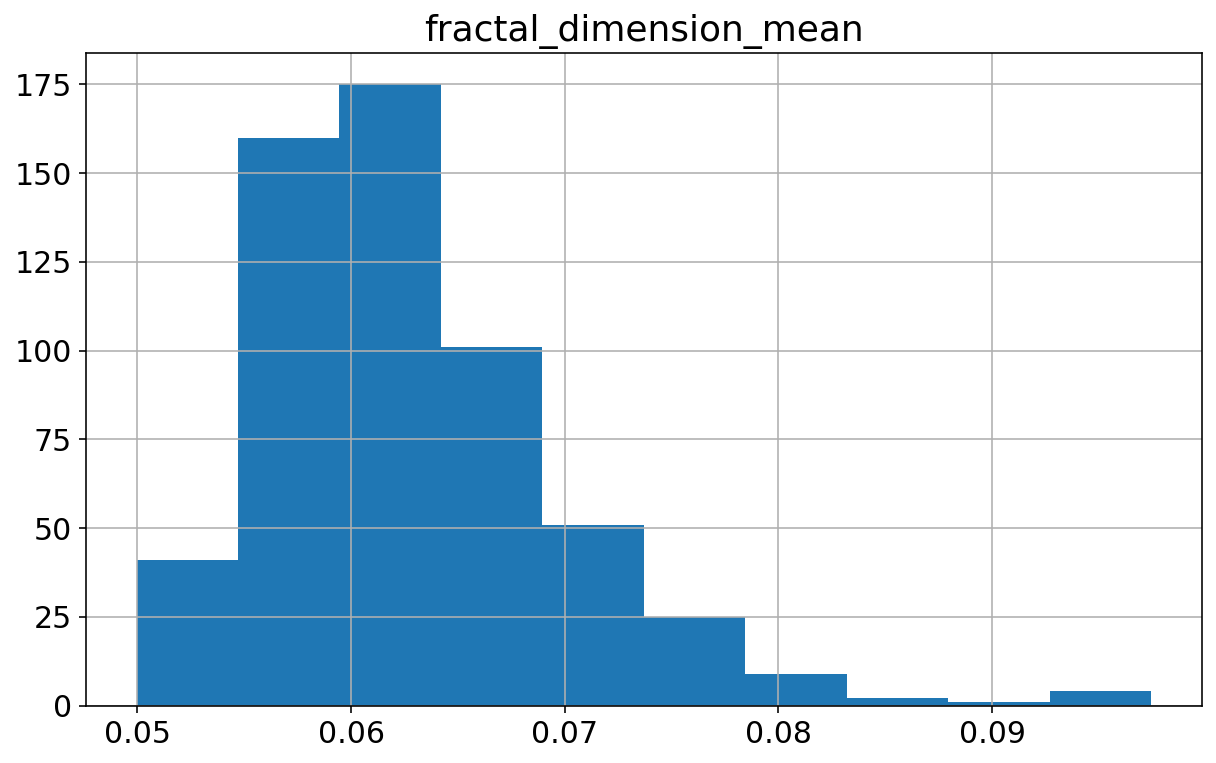

In [21]:
df.hist(column=['fractal_dimension_mean']);

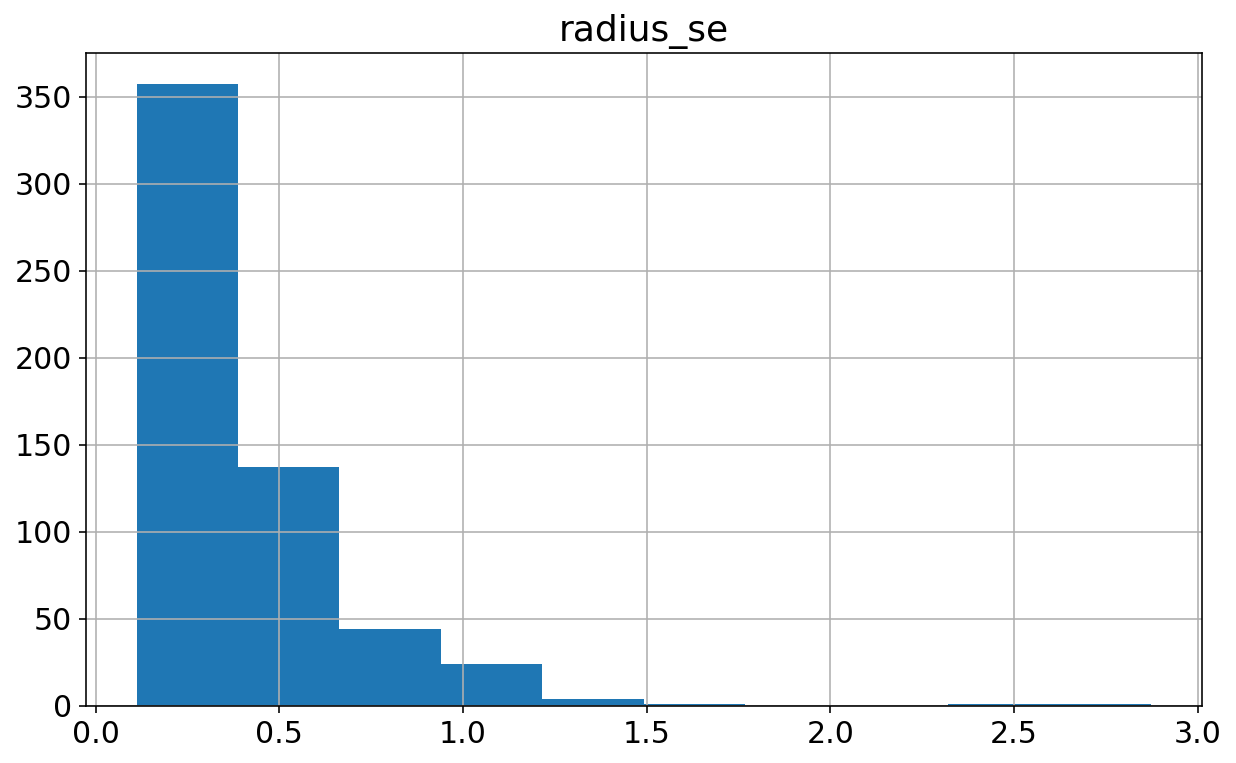

In [22]:
df.hist(column=['radius_se']);

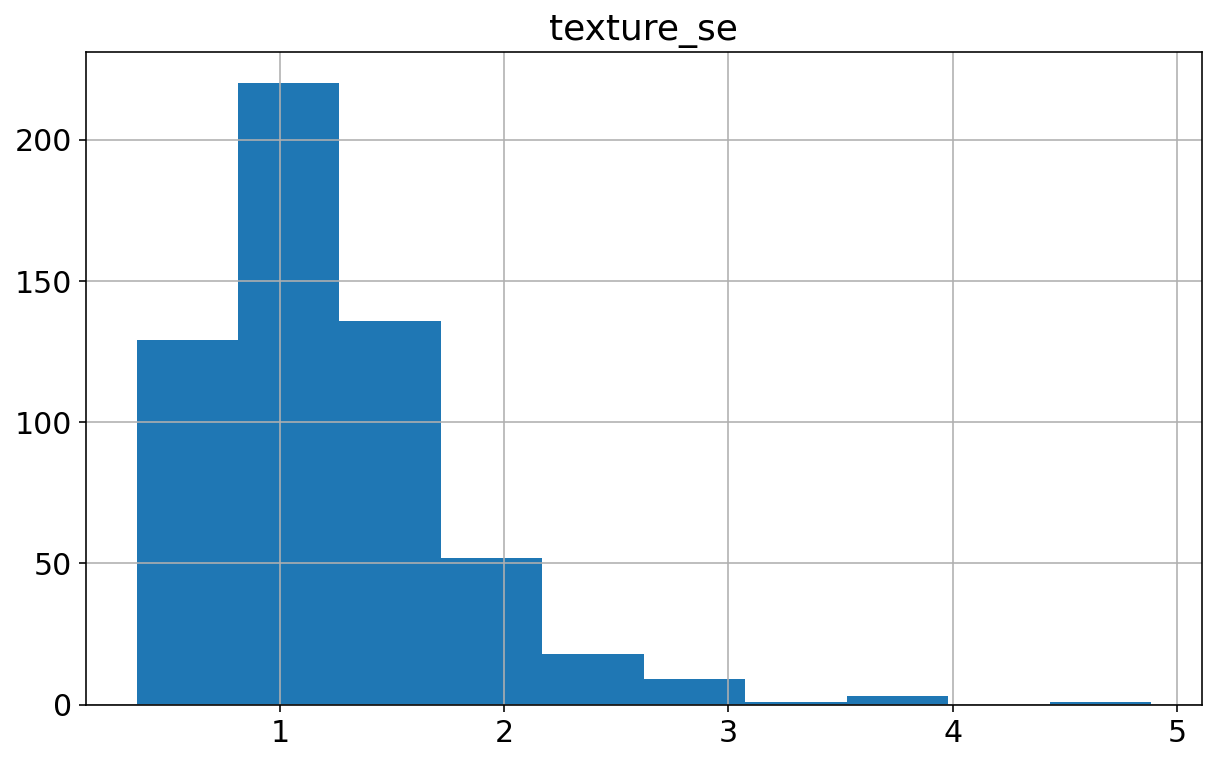

In [23]:
df.hist(column=['texture_se']);

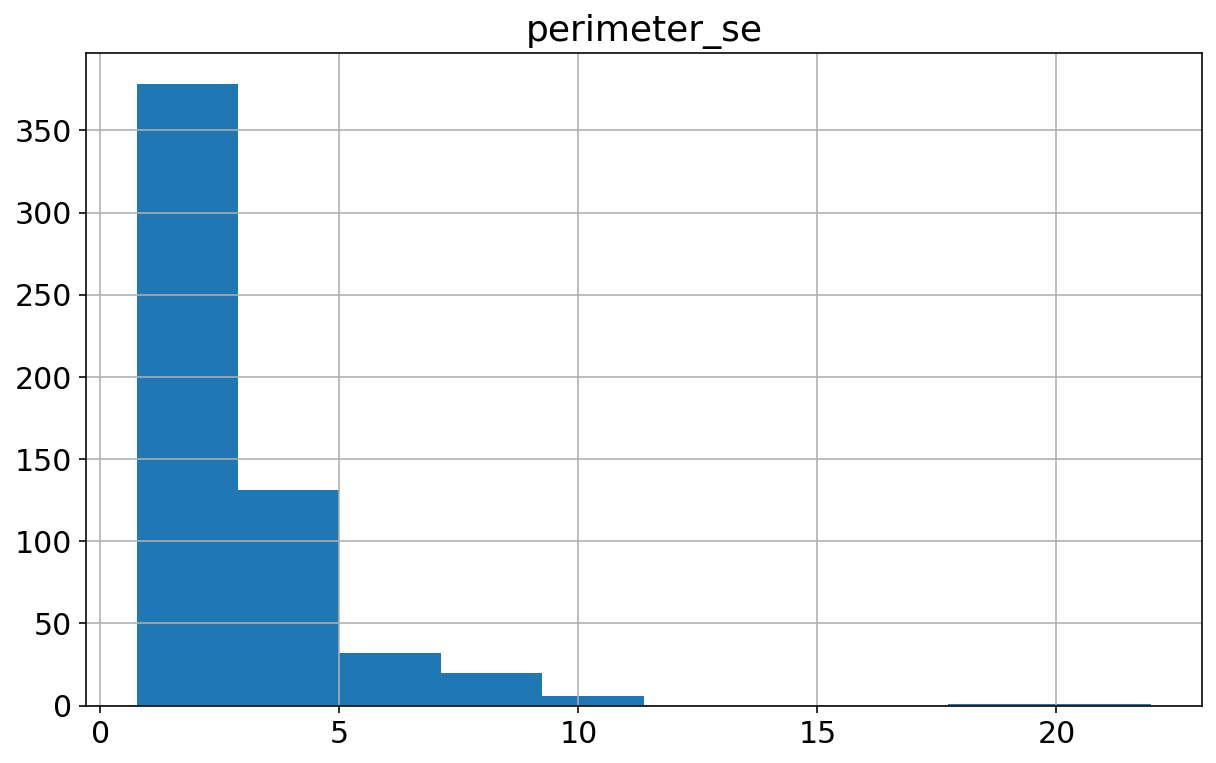

In [24]:
df.hist(column=['perimeter_se']);

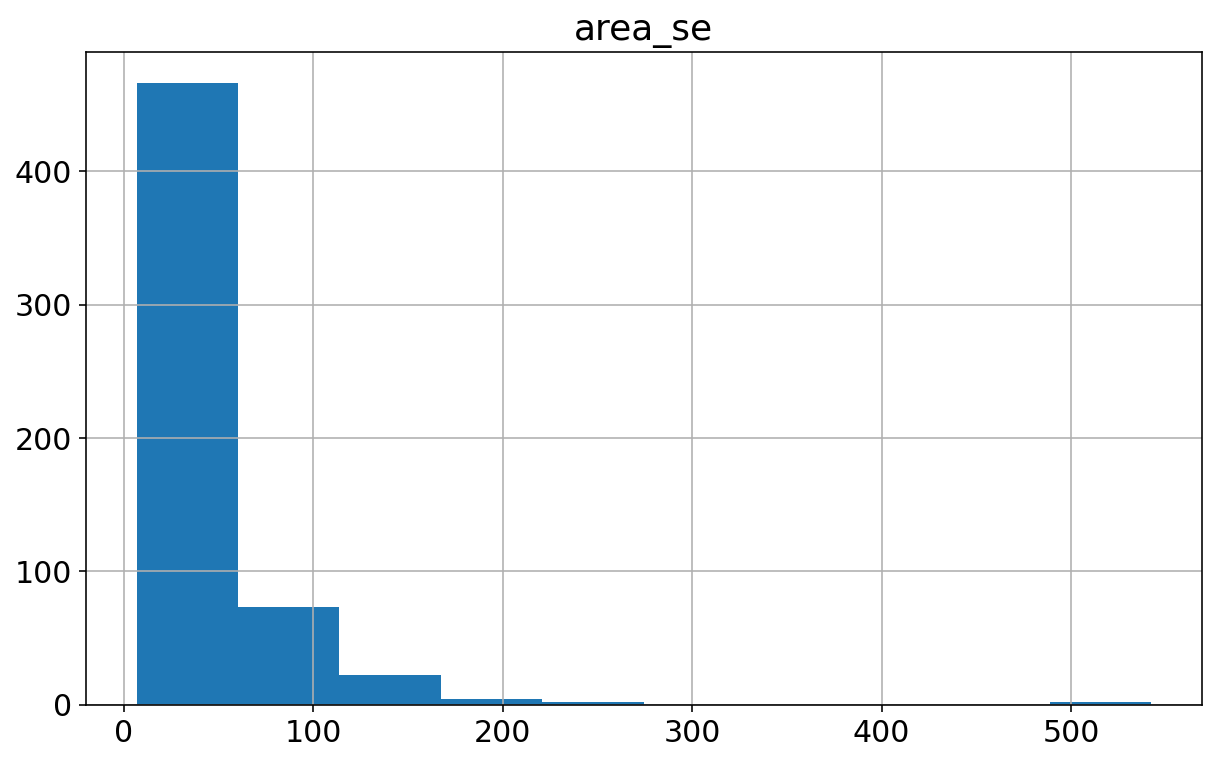

In [25]:
df.hist(column=['area_se']);

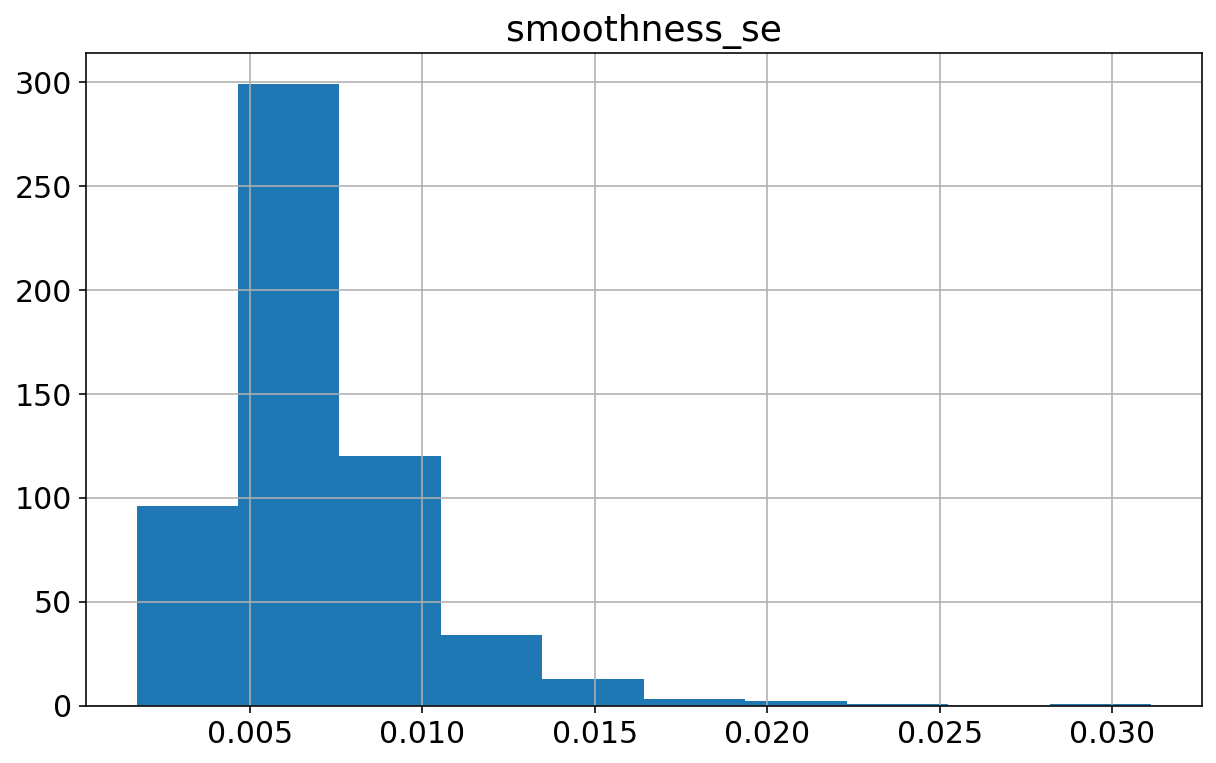

In [26]:
df.hist(column=['smoothness_se']);

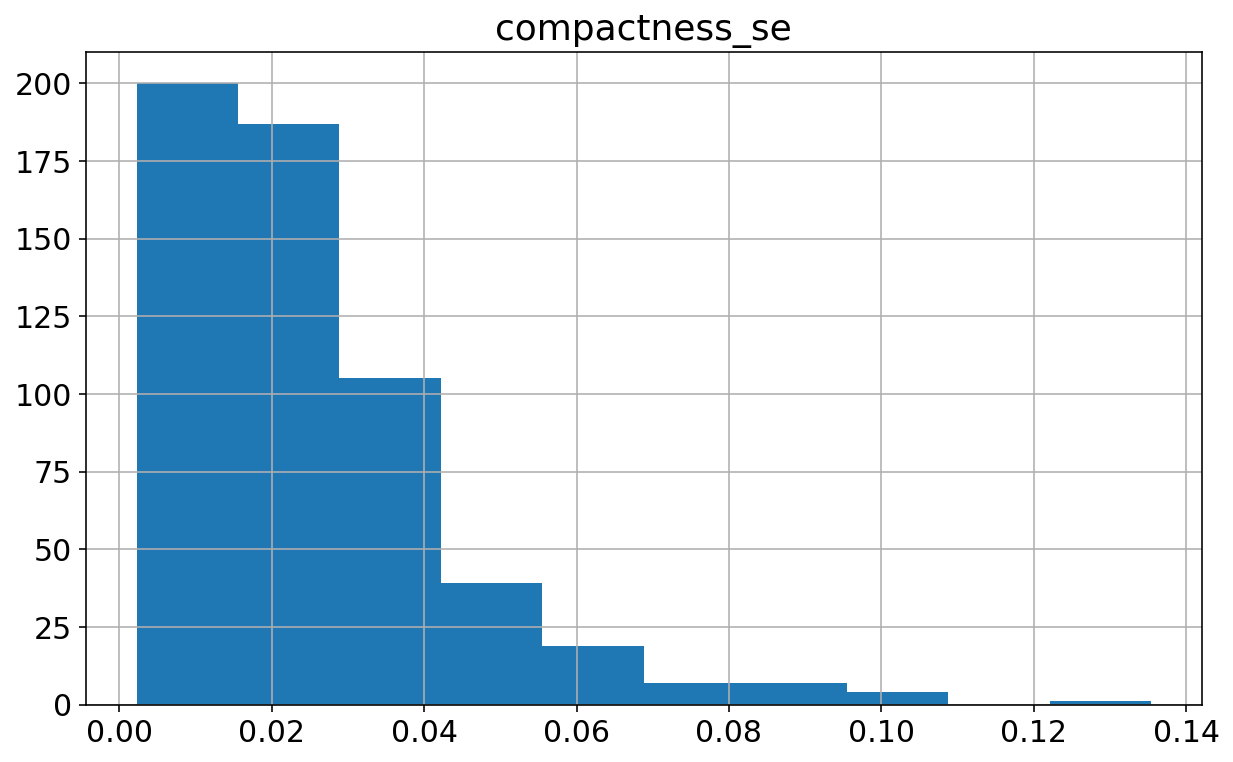

In [27]:
df.hist(column=['compactness_se']);

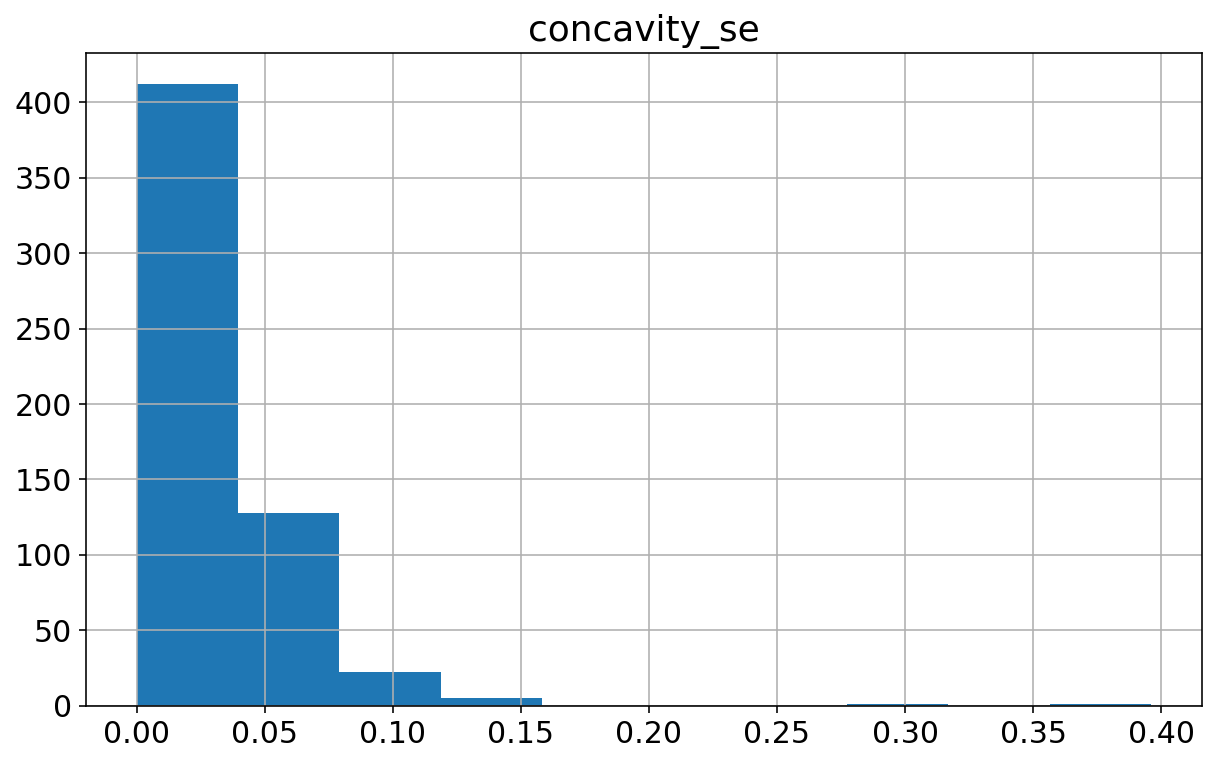

In [28]:
df.hist(column=['concavity_se']);

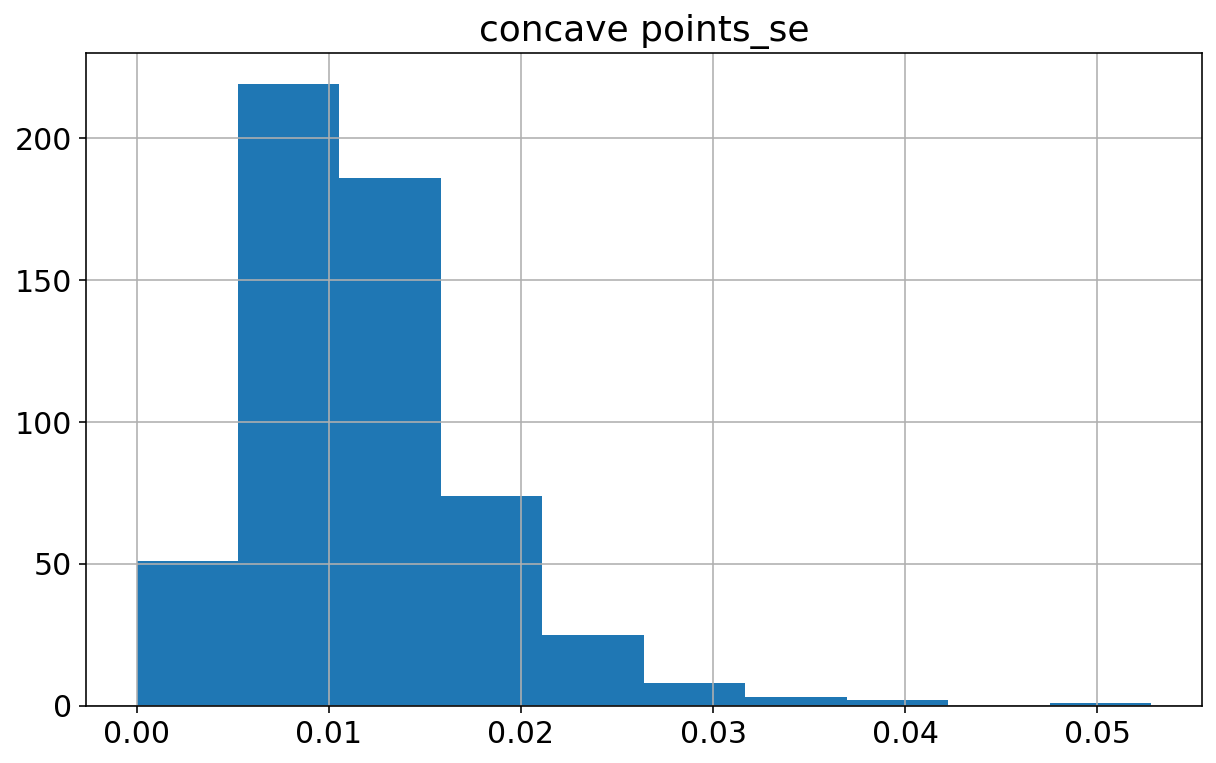

In [29]:
df.hist(column=['concave points_se']);

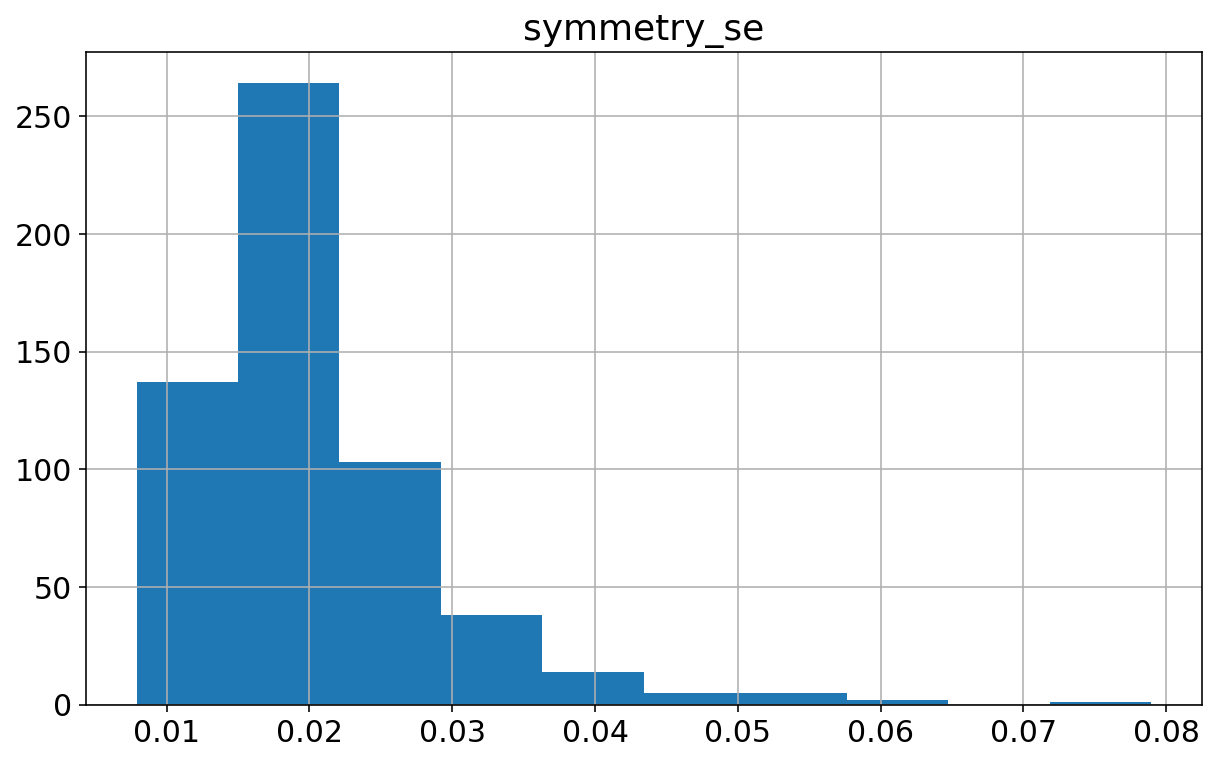

In [30]:
df.hist(column=['symmetry_se']);

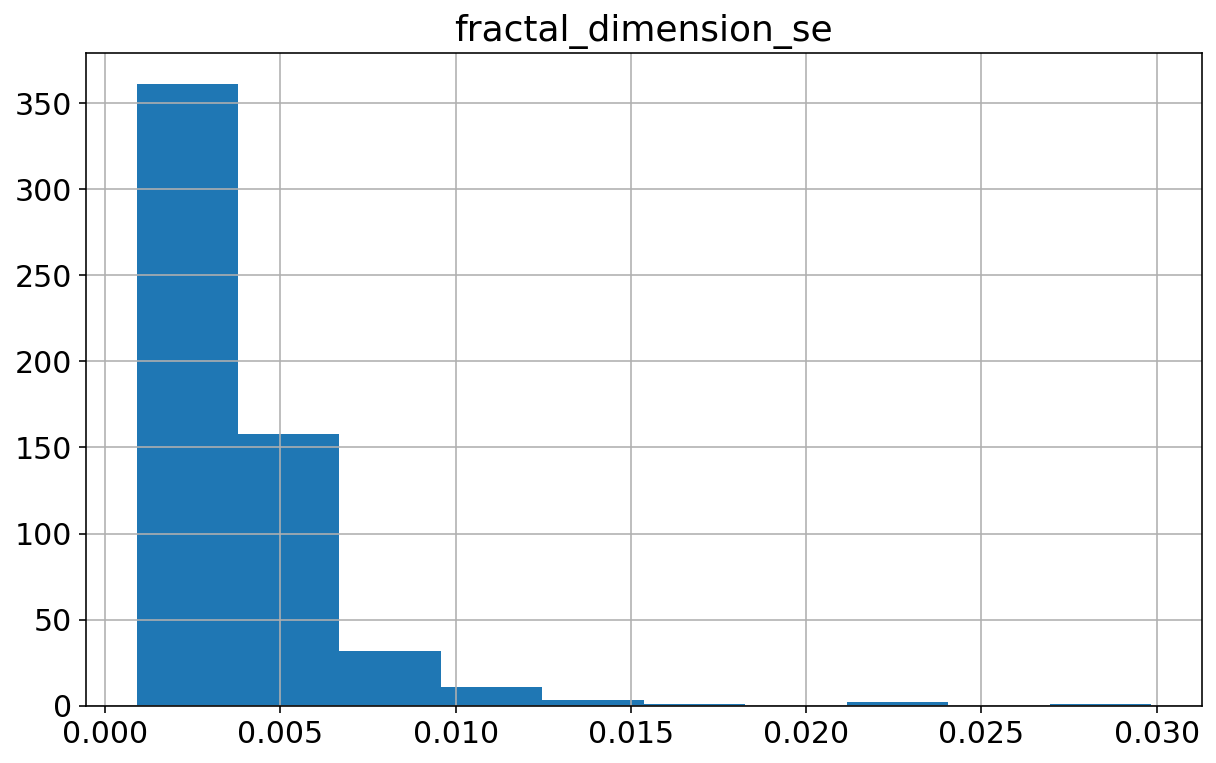

In [31]:
df.hist(column=['fractal_dimension_se']);

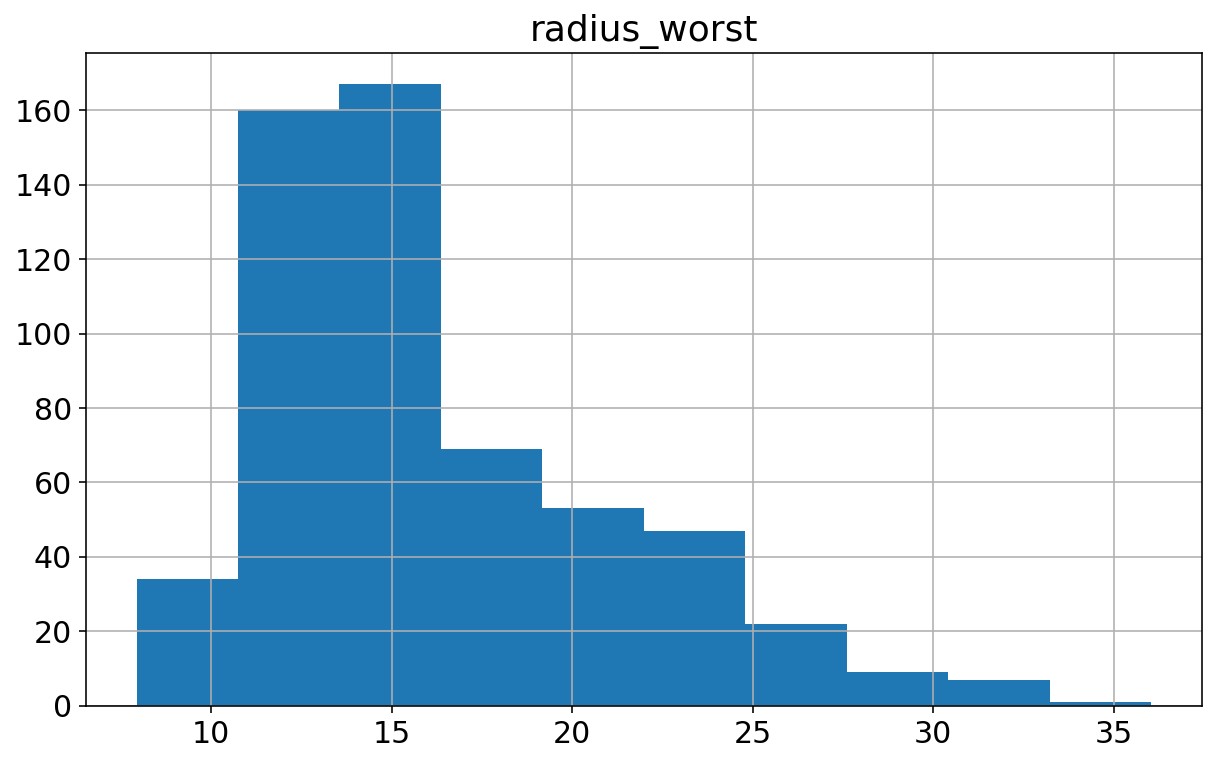

In [32]:
df.hist(column=['radius_worst']);

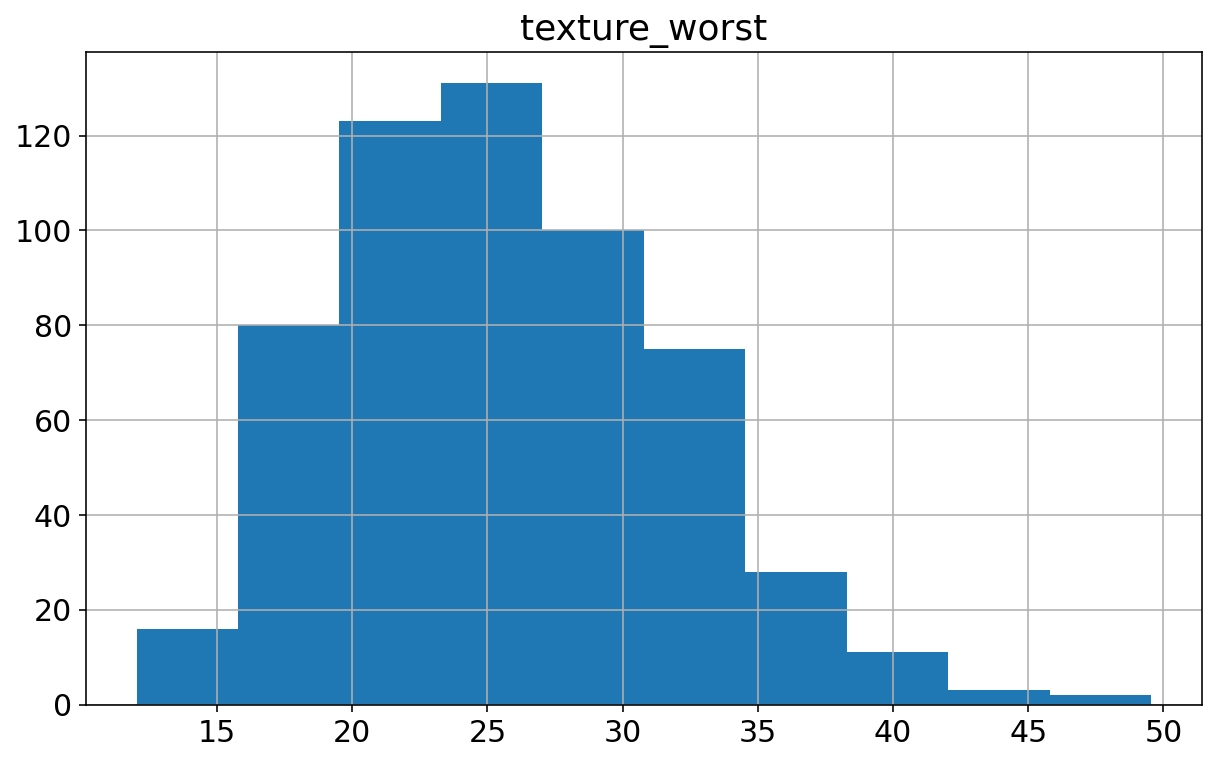

In [33]:
df.hist(column=['texture_worst']);

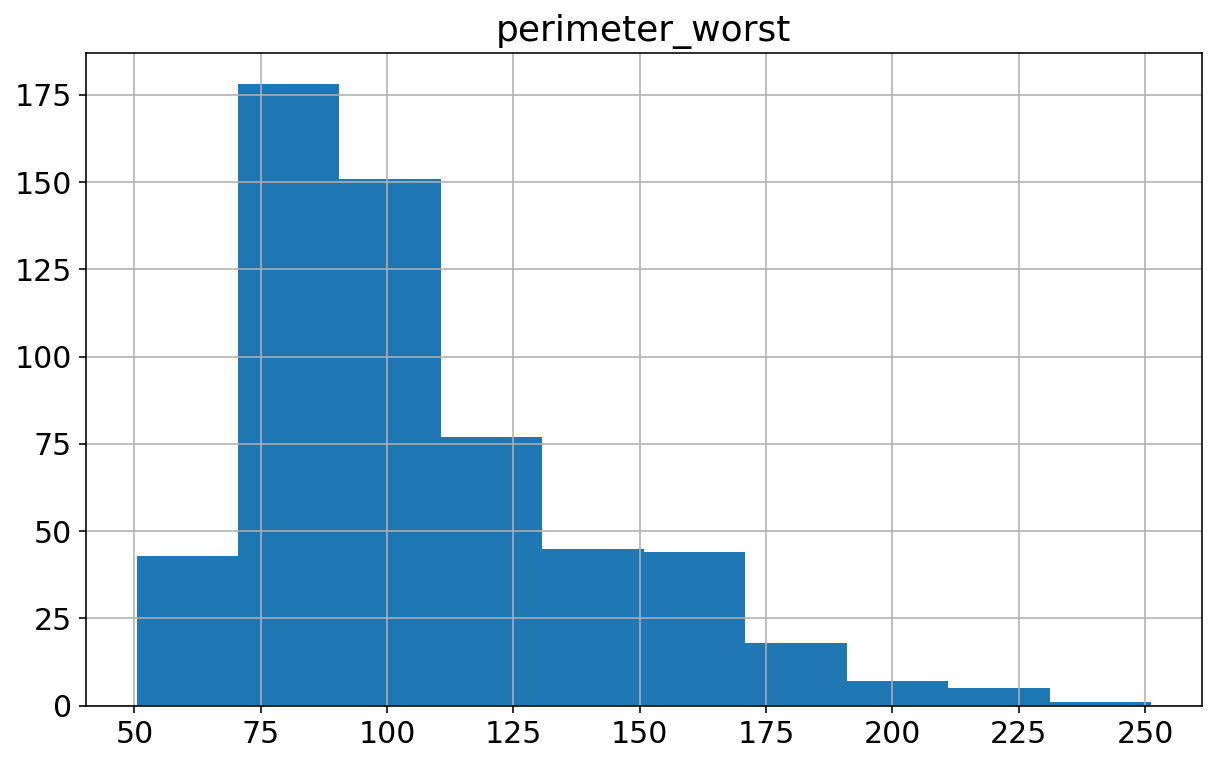

In [34]:
df.hist(column=['perimeter_worst']);

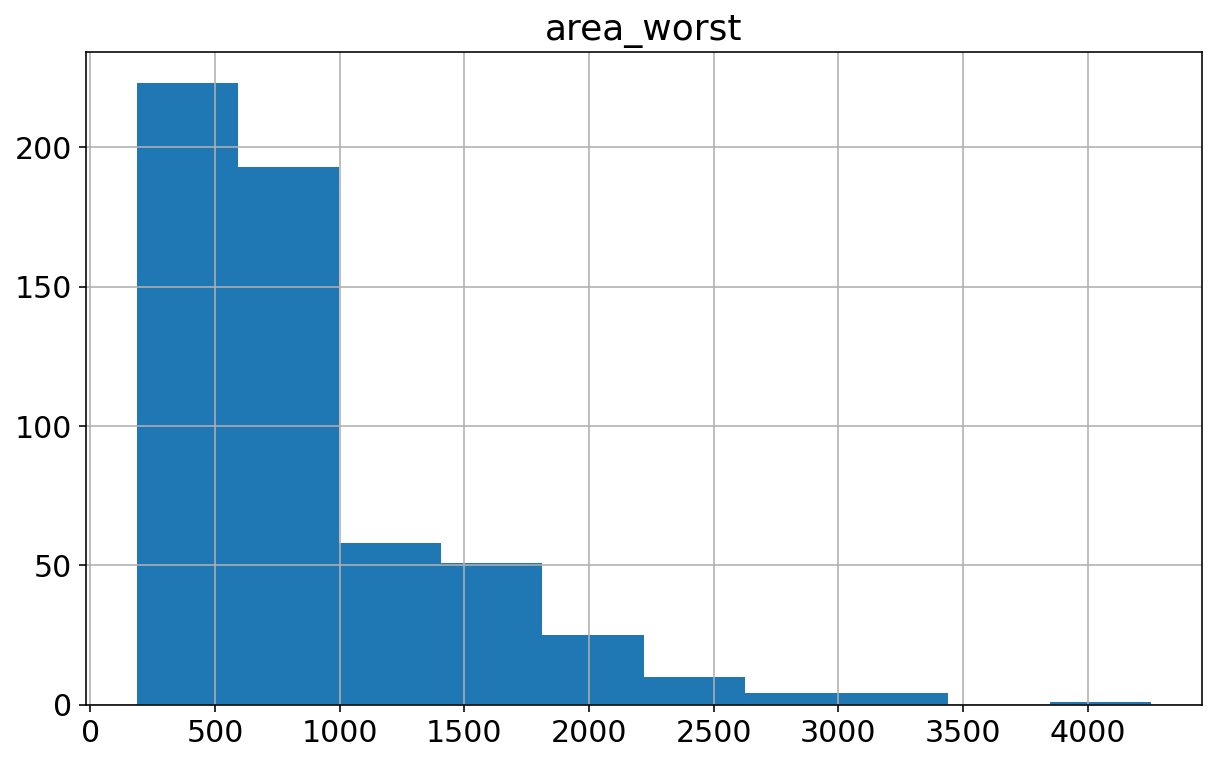

In [35]:
df.hist(column=['area_worst']);

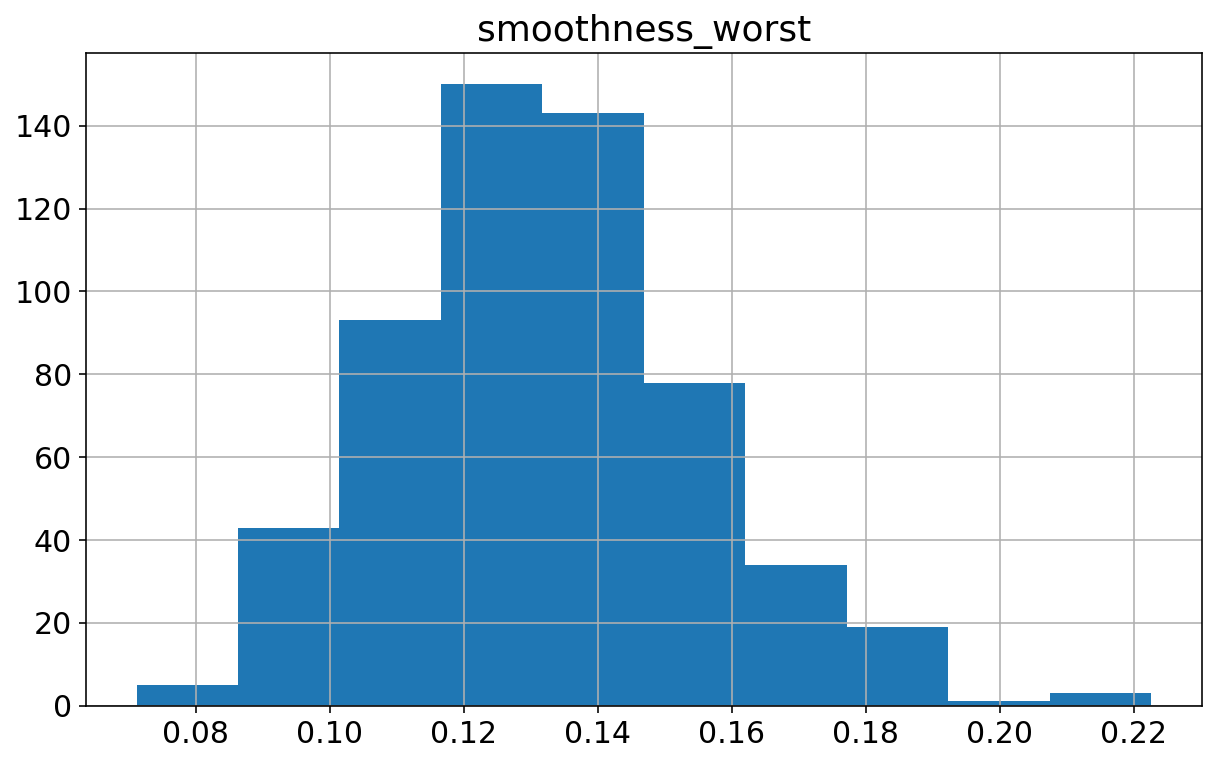

In [36]:
df.hist(column=['smoothness_worst']);

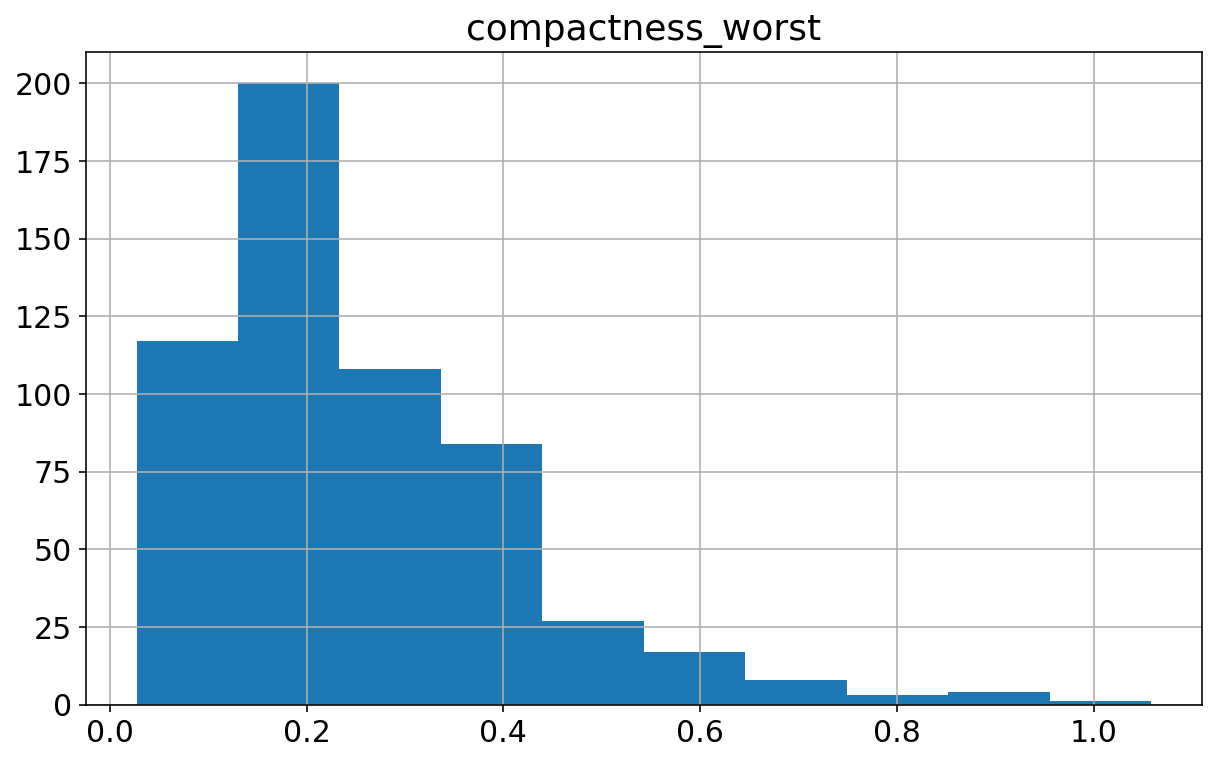

In [37]:
df.hist(column=['compactness_worst']);

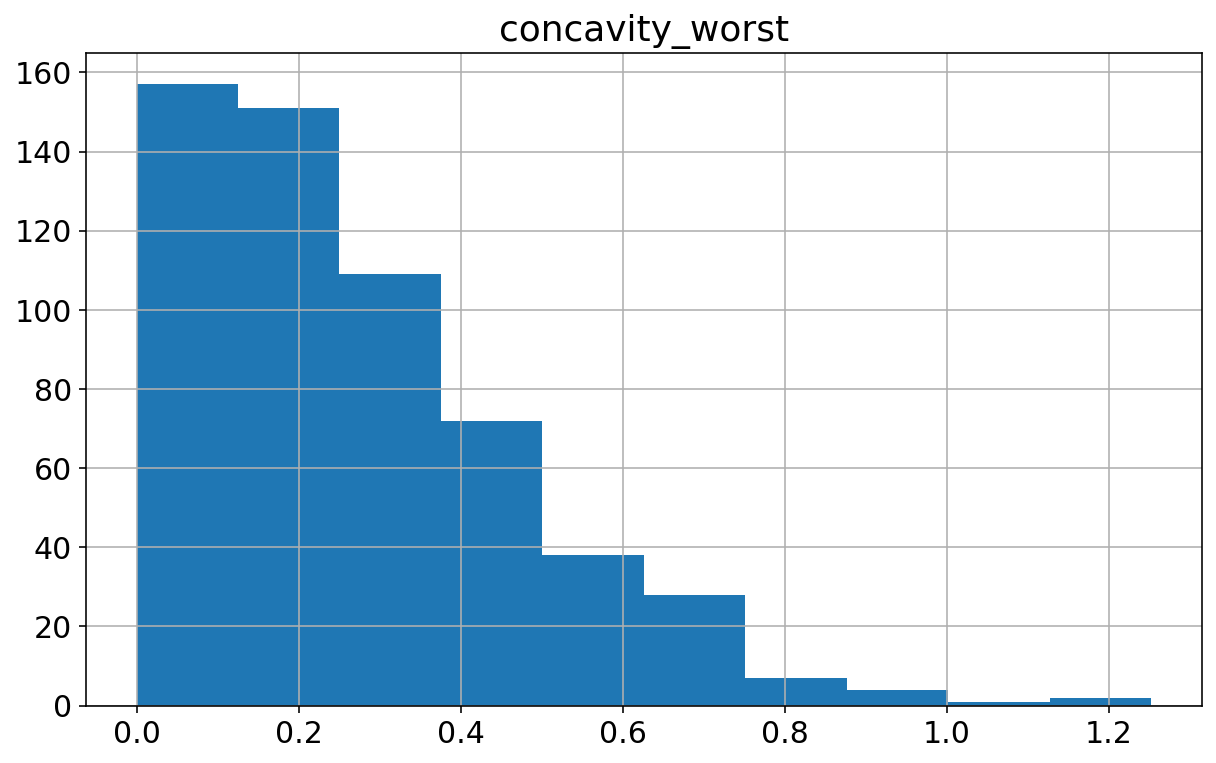

In [38]:
df.hist(column=['concavity_worst']);

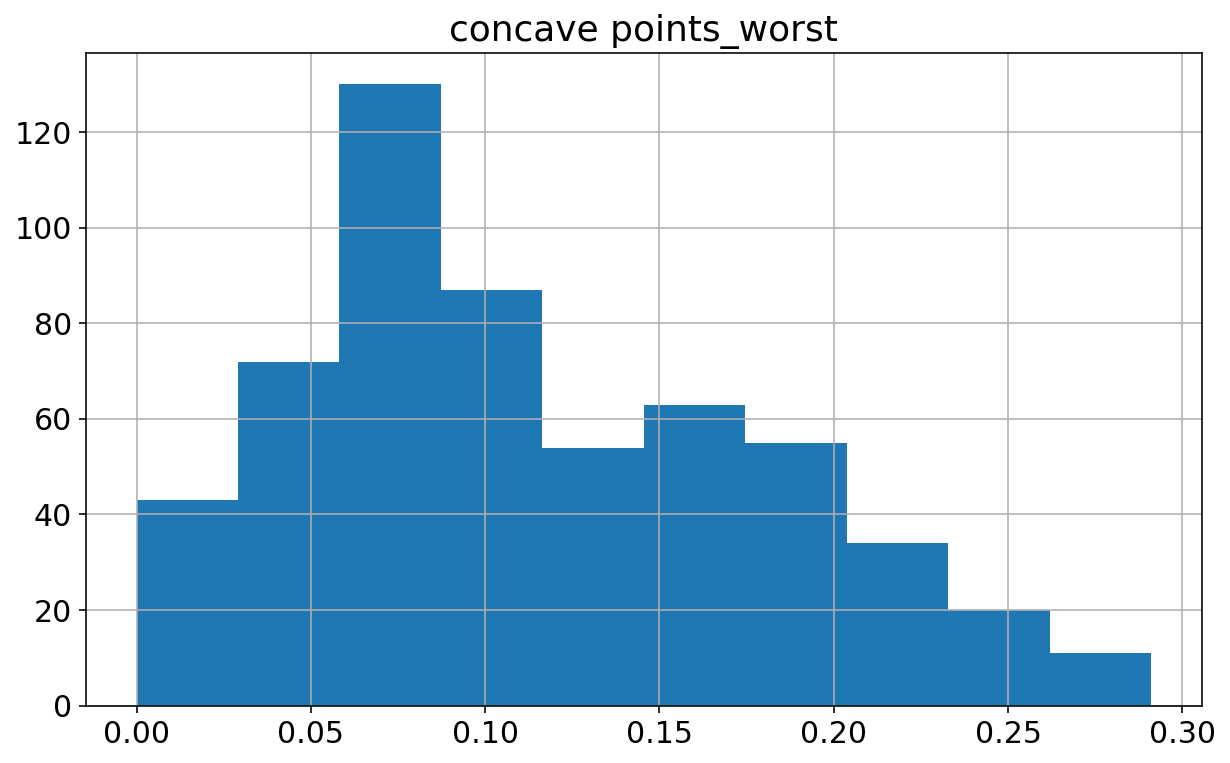

In [39]:
df.hist(column=['concave points_worst']);

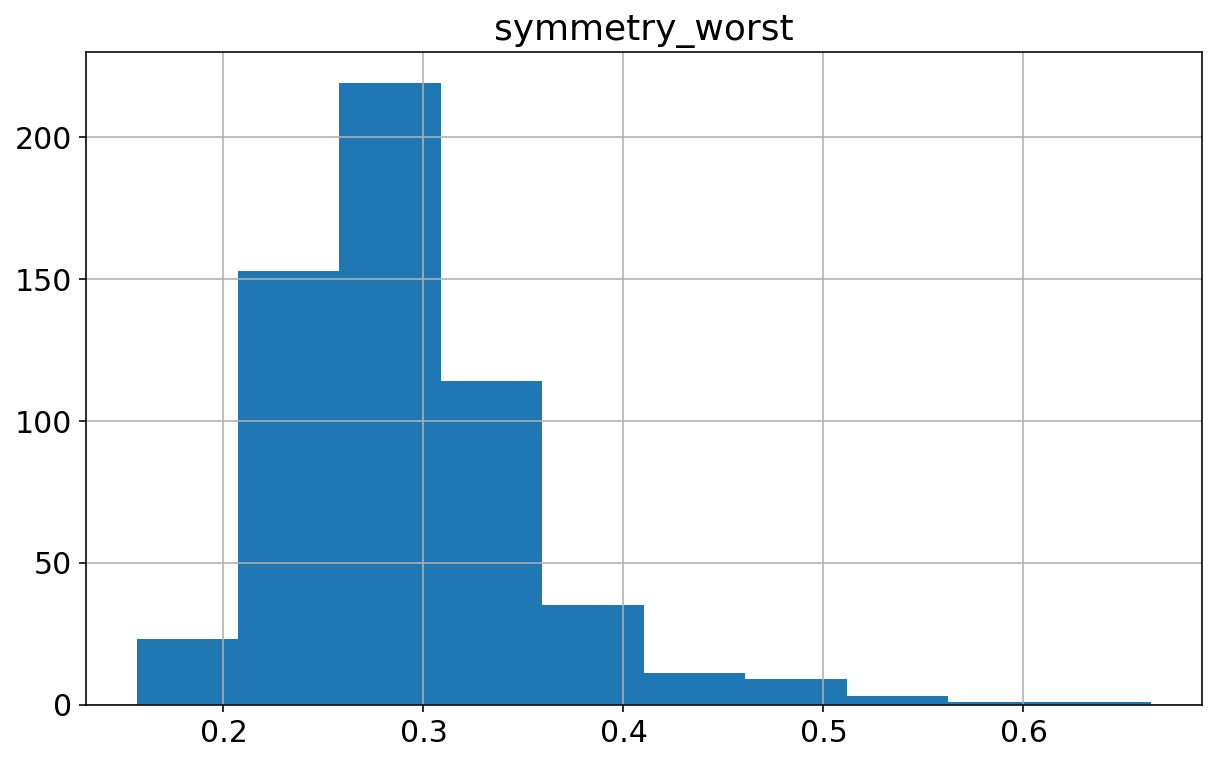

In [40]:
df.hist(column=['symmetry_worst']);

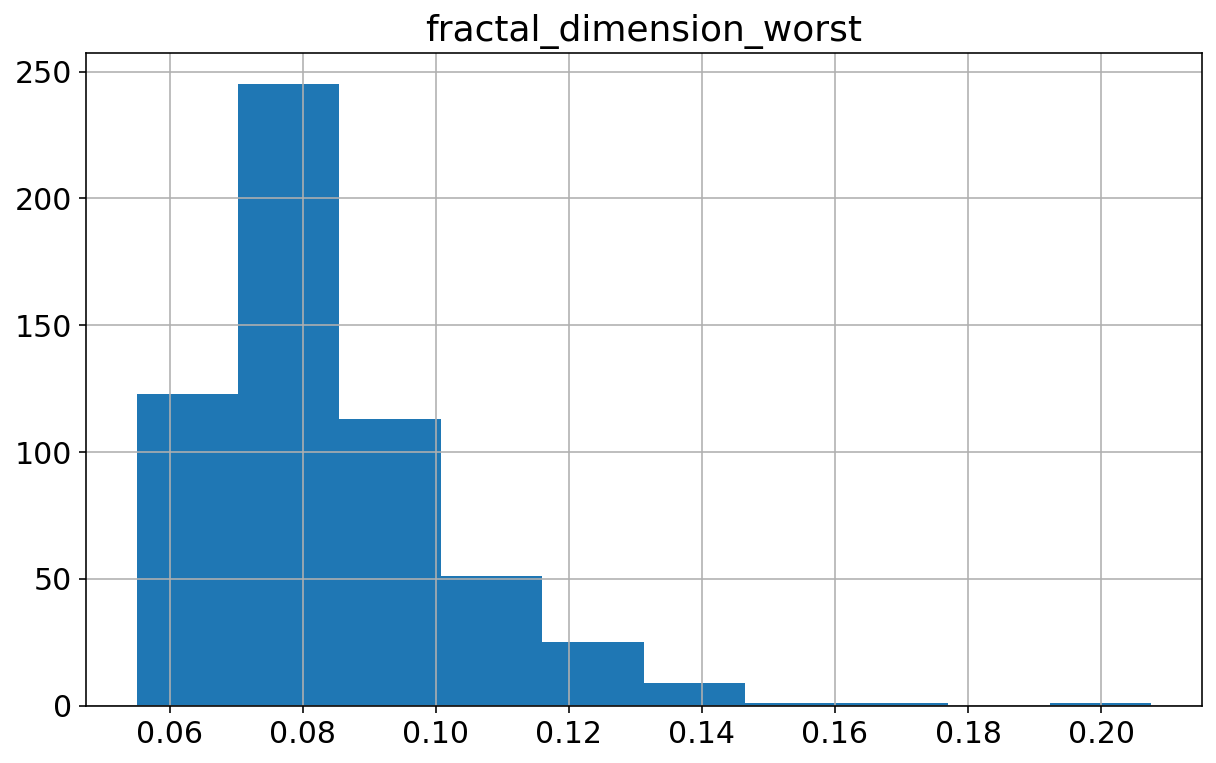

In [41]:
df.hist(column=['fractal_dimension_worst']);

##### Categorical feature - Bar Plots

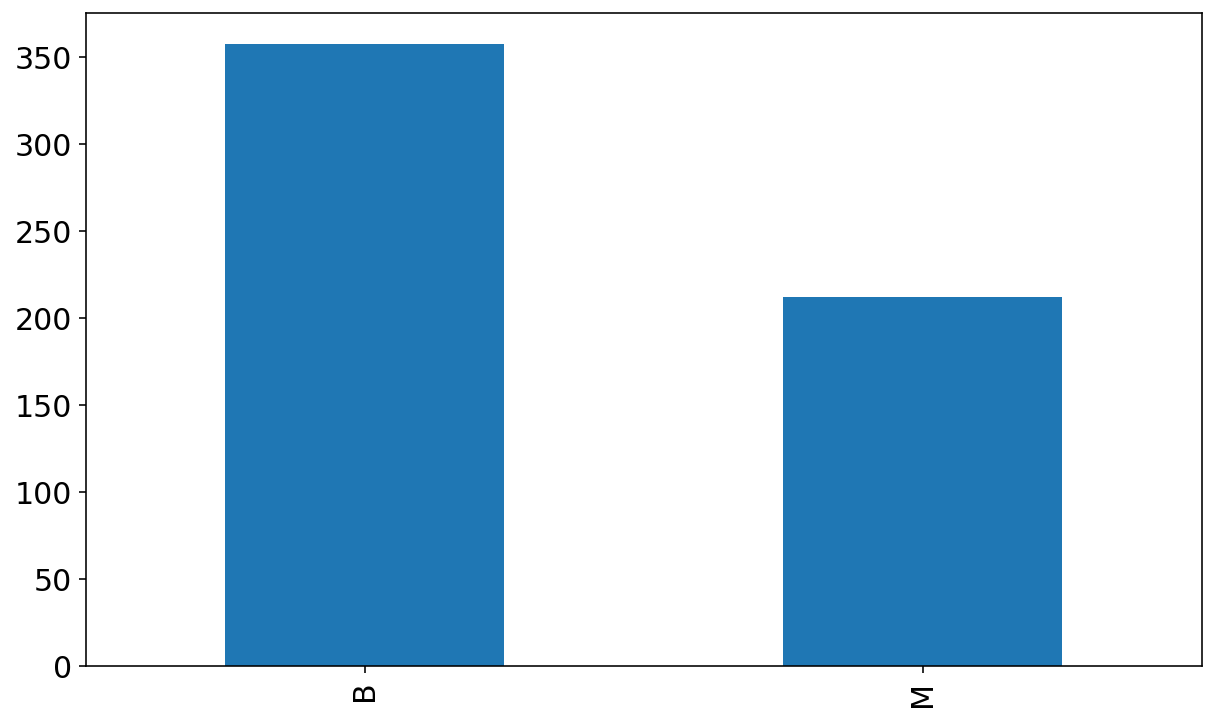

In [42]:
df['diagnosis'].value_counts().plot.bar();

### Data quality issues

#### Modify the target feature.

In [43]:
#Malignant value is set to 0, benign value is set to 1
df['diagnosis'].replace(["M", "B"], ["0", "1"], inplace=True)
df['diagnosis'] = df['diagnosis'].astype('int')

#### Missing values

In [44]:
# Dropping null values in rows
df.dropna()

,id,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
1,842517,0,20.57,21.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902
2,84300903,0,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
3,84348301,0,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
4,84358402,0,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,...,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,0,21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,...,25.45,26.4,166.1,2027.0,0.141,0.2113,0.4107,0.2216,0.206,0.07115
565,926682,0,20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,...,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
566,926954,0,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,...,18.98,34.12,126.7,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782
567,927241,0,20.6,29.33,140.1,1265.0,0.1178,0.277,0.3514,0.152,...,25.74,39.42,184.6,1821.0,0.165,0.8681,0.9387,0.265,0.4087,0.124


In [109]:
df1=df.iloc[:,2:]
correlation_matrix=df1.corr()
print(correlation_matrix)

                         Radius_mean  Texture_mean  perimeter_mean  area_mean  \
Radius_mean                 1.000000      0.326716        0.997855   0.987357   
Texture_mean                0.326716      1.000000        0.332231   0.324149   
perimeter_mean              0.997855      0.332231        1.000000   0.986507   
area_mean                   0.987357      0.324149        0.986507   1.000000   
smoothness_mean             0.170581     -0.024737        0.207278   0.177028   
compactness_mean            0.506124      0.235863        0.556936   0.498502   
concavity_mean              0.676764      0.302324        0.716136   0.685983   
concave points_mean         0.822529      0.294307        0.850977   0.823269   
symmetry_mean               0.147741      0.071390        0.183027   0.151293   
fractal_dimension_mean     -0.311631     -0.077844       -0.261477  -0.283110   
radius_se                   0.679090      0.276635        0.691765   0.732562   
texture_se                 -

#### PCA

array([0.54794517, 0.2519959 ])

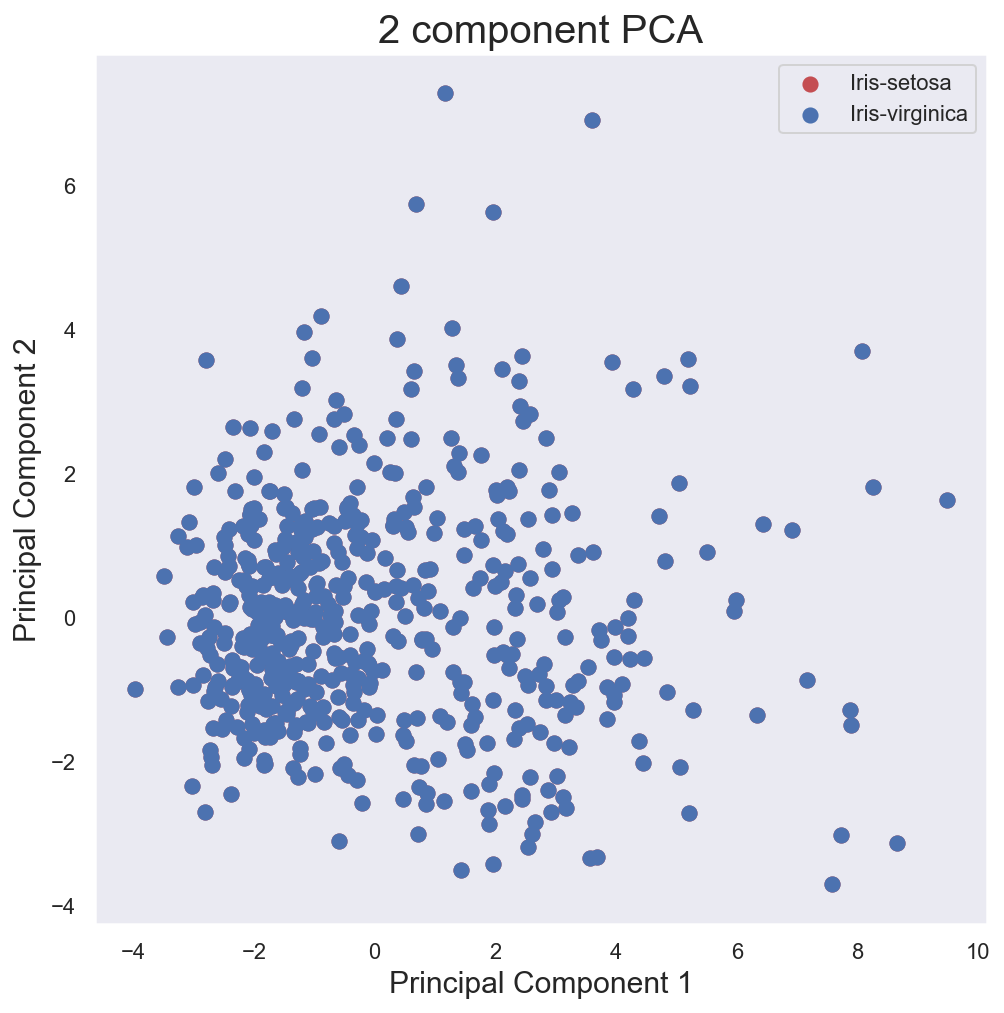

In [182]:
#PCA
df2=df.iloc[:,1:12]
# Separating out the features
x = df2.iloc[:,1:12]
# Separating out the target
y = df2.loc[:,['diagnosis']]
# Standardizing the features
X = StandardScaler().fit_transform(x)
X = pd.DataFrame(X,columns=['radius_mean','Texture_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean','concave points_mean','symmetry_mean','fractal_dimension_mean'])
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf
finalDf = pd.concat([principalDf, df[['diagnosis']]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['Iris-setosa', 'Iris-virginica']
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['diagnosis'] == target
    ax.scatter(finalDf.iloc[:,0]
               , finalDf.iloc[:,1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
pca.explained_variance_ratio_


In [175]:
finalDf.iloc[:,0]

0      5.221448
1      1.872559
2      3.969548
3      3.594393
4      3.150314
         ...   
564    4.437050
565    2.876037
566    0.650928
567    6.905714
568   -3.969797
Name: principal component 1, Length: 569, dtype: float64

There are no missing values in the dataset.

#### Irregular cardinality

In [45]:
# Get unique values of each column in the dataframe
uniqueValues = df.nunique()
print(len(df))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print((uniqueValues))

569
id                         569
diagnosis                    2
Radius_mean                456
Texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
dtyp

In [78]:
df

,id,diagnosis,Radius_mean,Texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,0,17.99,10.38,122.8,1001.0,0.1184,0.2776,0.3001,0.1471,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.1189
1,842517,0,20.57,21.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.186,0.275,0.08902
2,84300903,0,19.69,21.25,130.0,1203.0,0.1096,0.1599,0.1974,0.1279,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.243,0.3613,0.08758
3,84348301,0,11.42,20.38,77.58,386.1,0.1425,0.2839,0.2414,0.1052,...,14.91,26.5,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.173
4,84358402,0,20.29,14.34,135.1,1297.0,0.1003,0.1328,0.198,0.1043,...,22.54,16.67,152.2,1575.0,0.1374,0.205,0.4,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,0,21.56,22.39,142.0,1479.0,0.111,0.1159,0.2439,0.1389,...,25.45,26.4,166.1,2027.0,0.141,0.2113,0.4107,0.2216,0.206,0.07115
565,926682,0,20.13,28.25,131.2,1261.0,0.0978,0.1034,0.144,0.09791,...,23.69,38.25,155.0,1731.0,0.1166,0.1922,0.3215,0.1628,0.2572,0.06637
566,926954,0,16.6,28.08,108.3,858.1,0.08455,0.1023,0.09251,0.05302,...,18.98,34.12,126.7,1124.0,0.1139,0.3094,0.3403,0.1418,0.2218,0.0782
567,927241,0,20.6,29.33,140.1,1265.0,0.1178,0.277,0.3514,0.152,...,25.74,39.42,184.6,1821.0,0.165,0.8681,0.9387,0.265,0.4087,0.124


As we can see, the following common issues do not appear in the dataframe:

* Features with a cardinality of 1
* Too high cardinality for categorical features
* Too low cardinality for continous features

Hence we do not need to drop any column

#### Boxplot for each variables
#### Radius

<AxesSubplot:>

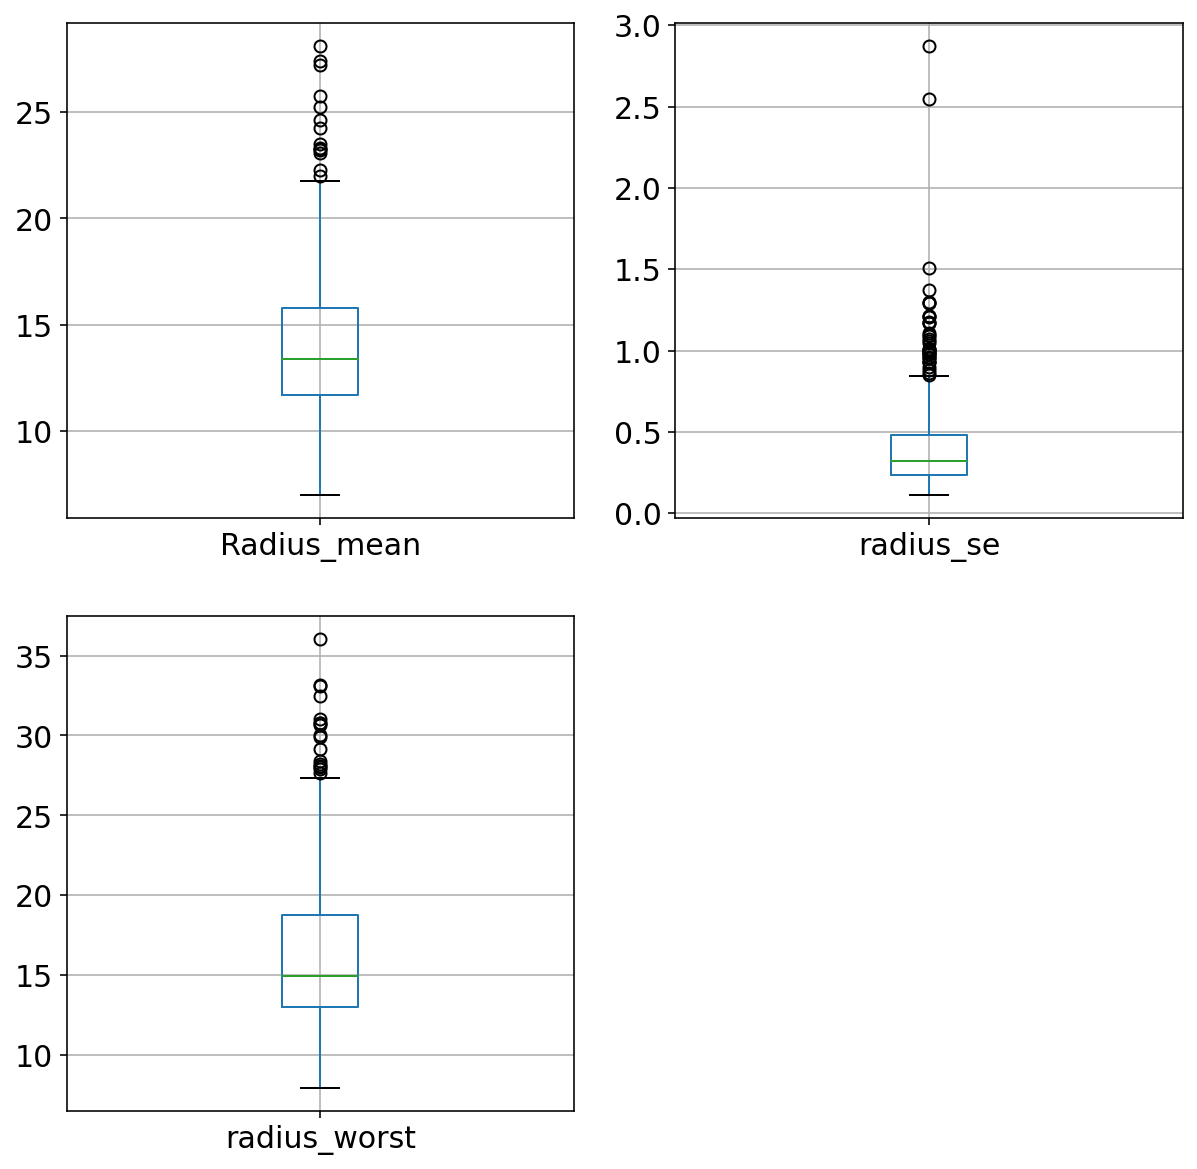

In [90]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('Radius_mean')
plt.subplot(2,2,2)
df.boxplot('radius_se')
plt.subplot(2,2,3)
df.boxplot('radius_worst')


#### Texture

<AxesSubplot:>

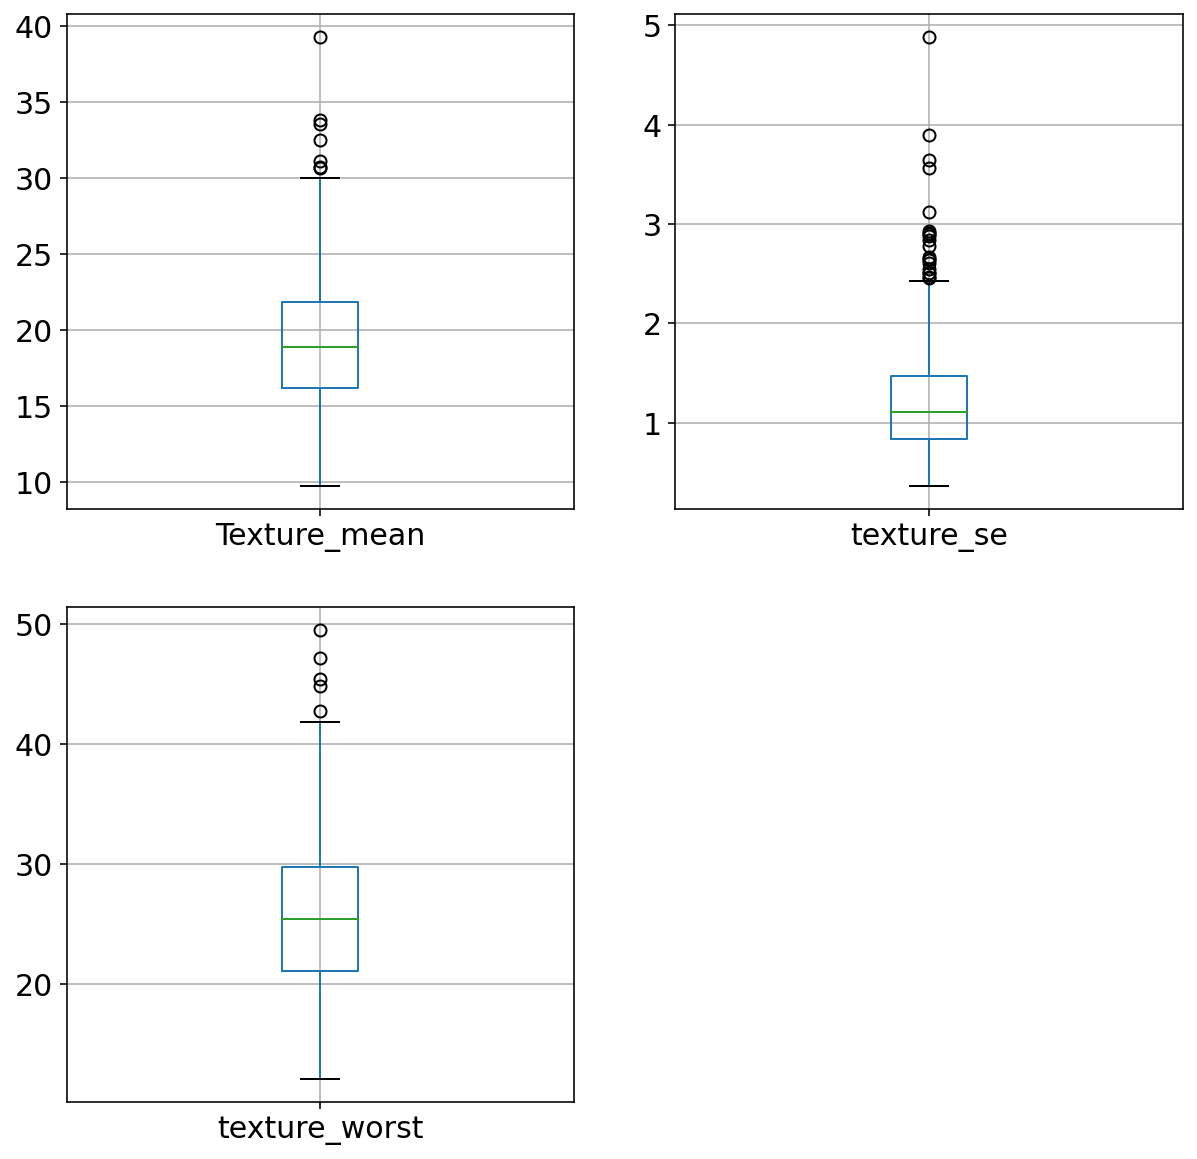

In [91]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('Texture_mean')
plt.subplot(2,2,2)
df.boxplot('texture_se')
plt.subplot(2,2,3)
df.boxplot('texture_worst')

#### Perimeter

<AxesSubplot:>

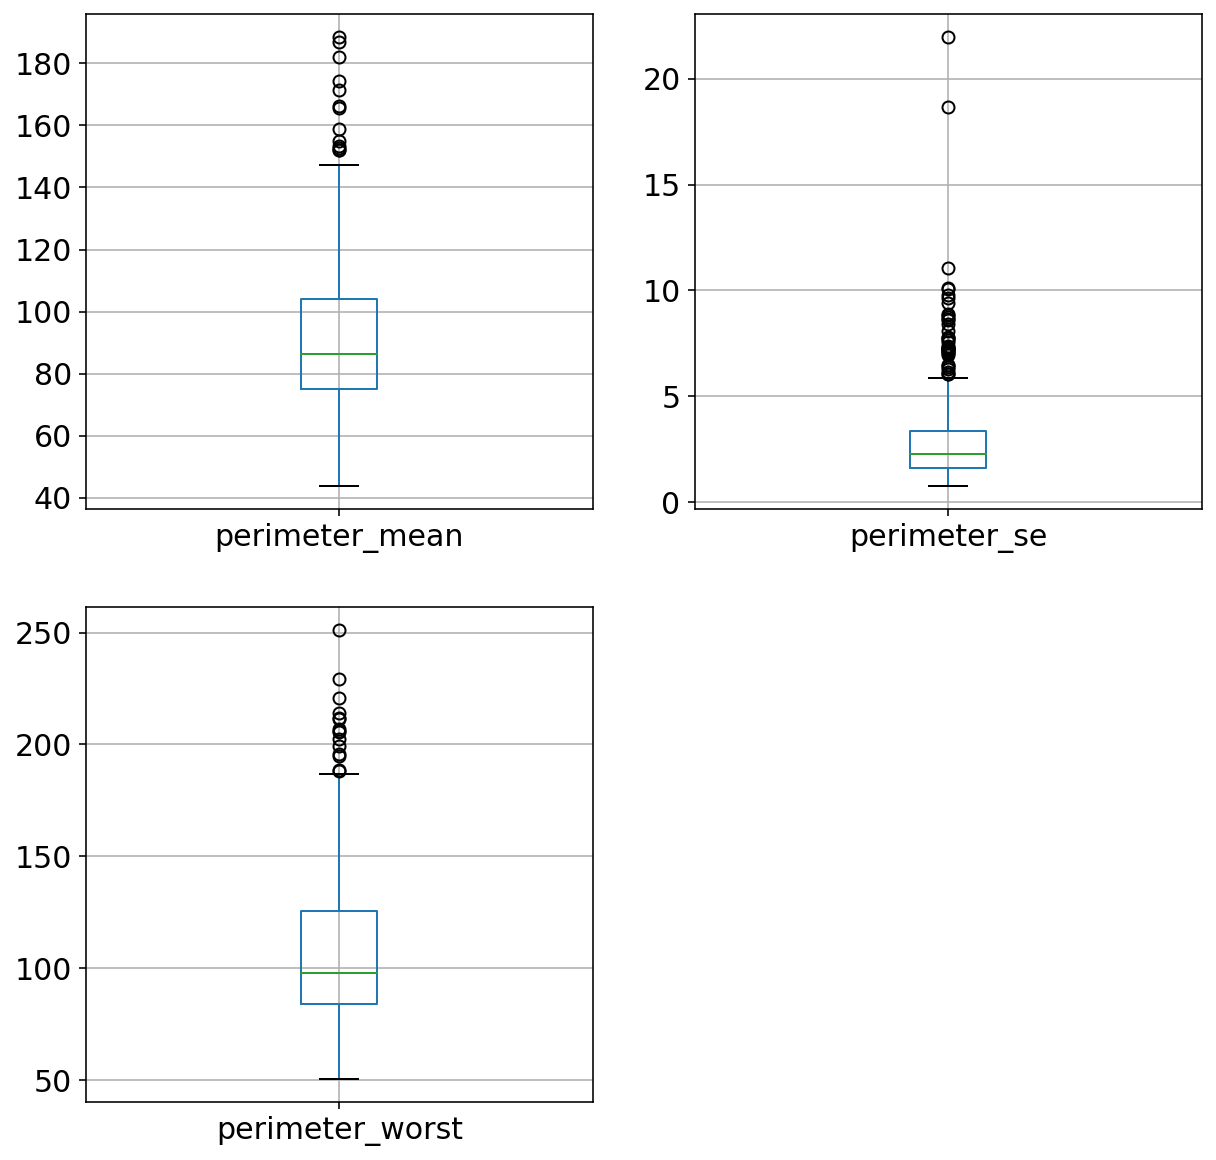

In [93]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('perimeter_mean')
plt.subplot(2,2,2)
df.boxplot('perimeter_se')
plt.subplot(2,2,3)
df.boxplot('perimeter_worst')

#### Area

<AxesSubplot:>

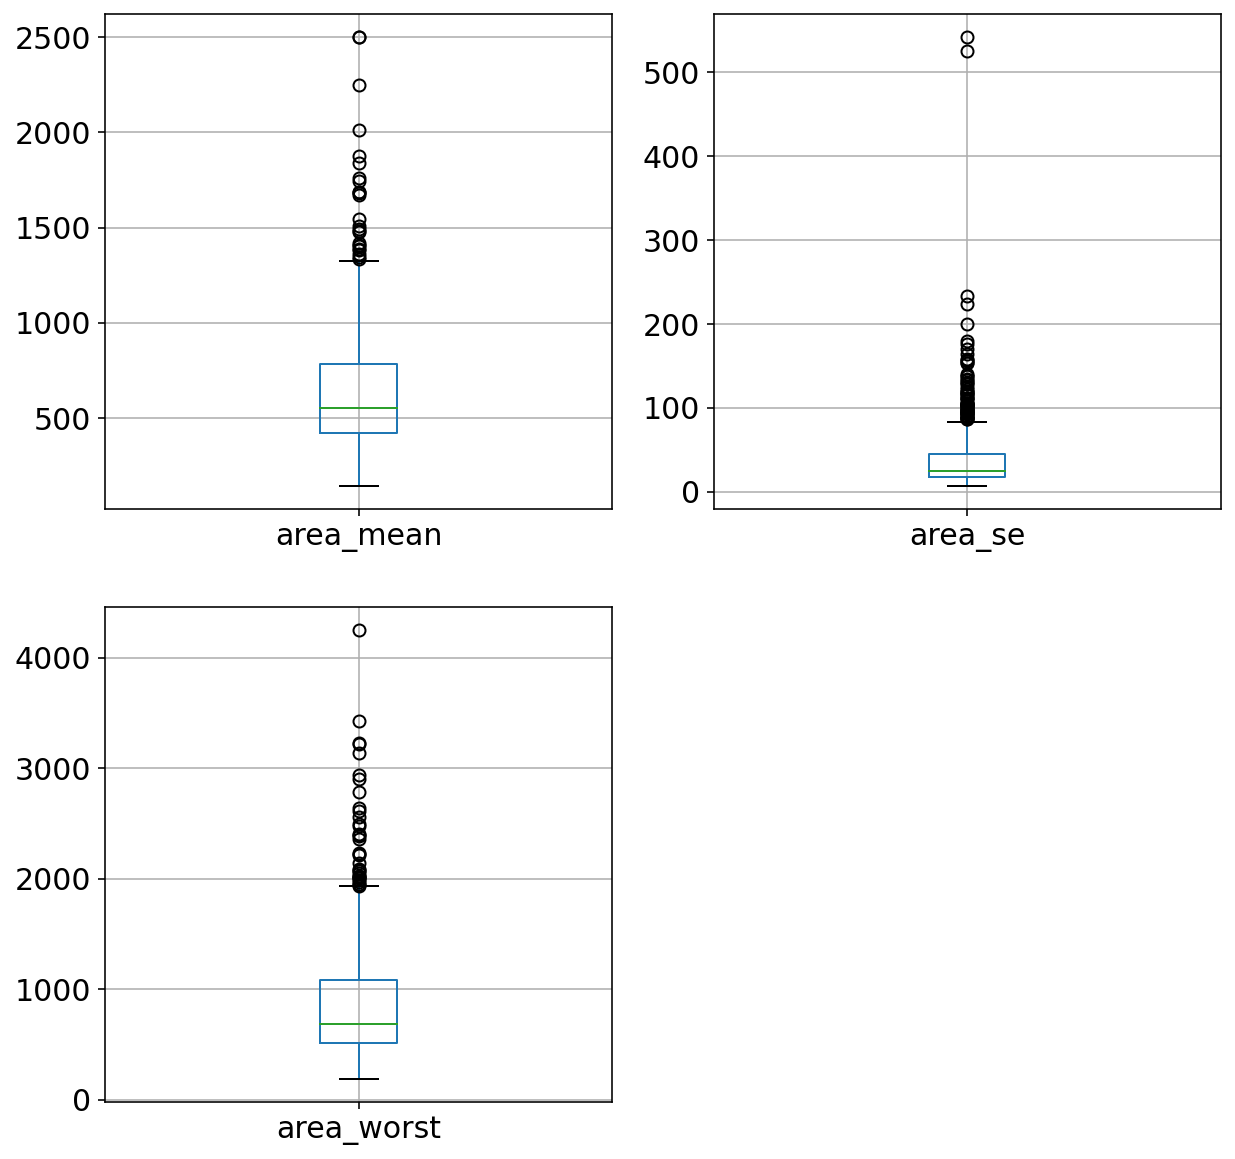

In [94]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('area_mean')
plt.subplot(2,2,2)
df.boxplot('area_se')
plt.subplot(2,2,3)
df.boxplot('area_worst')

#### Smoothness

<AxesSubplot:>

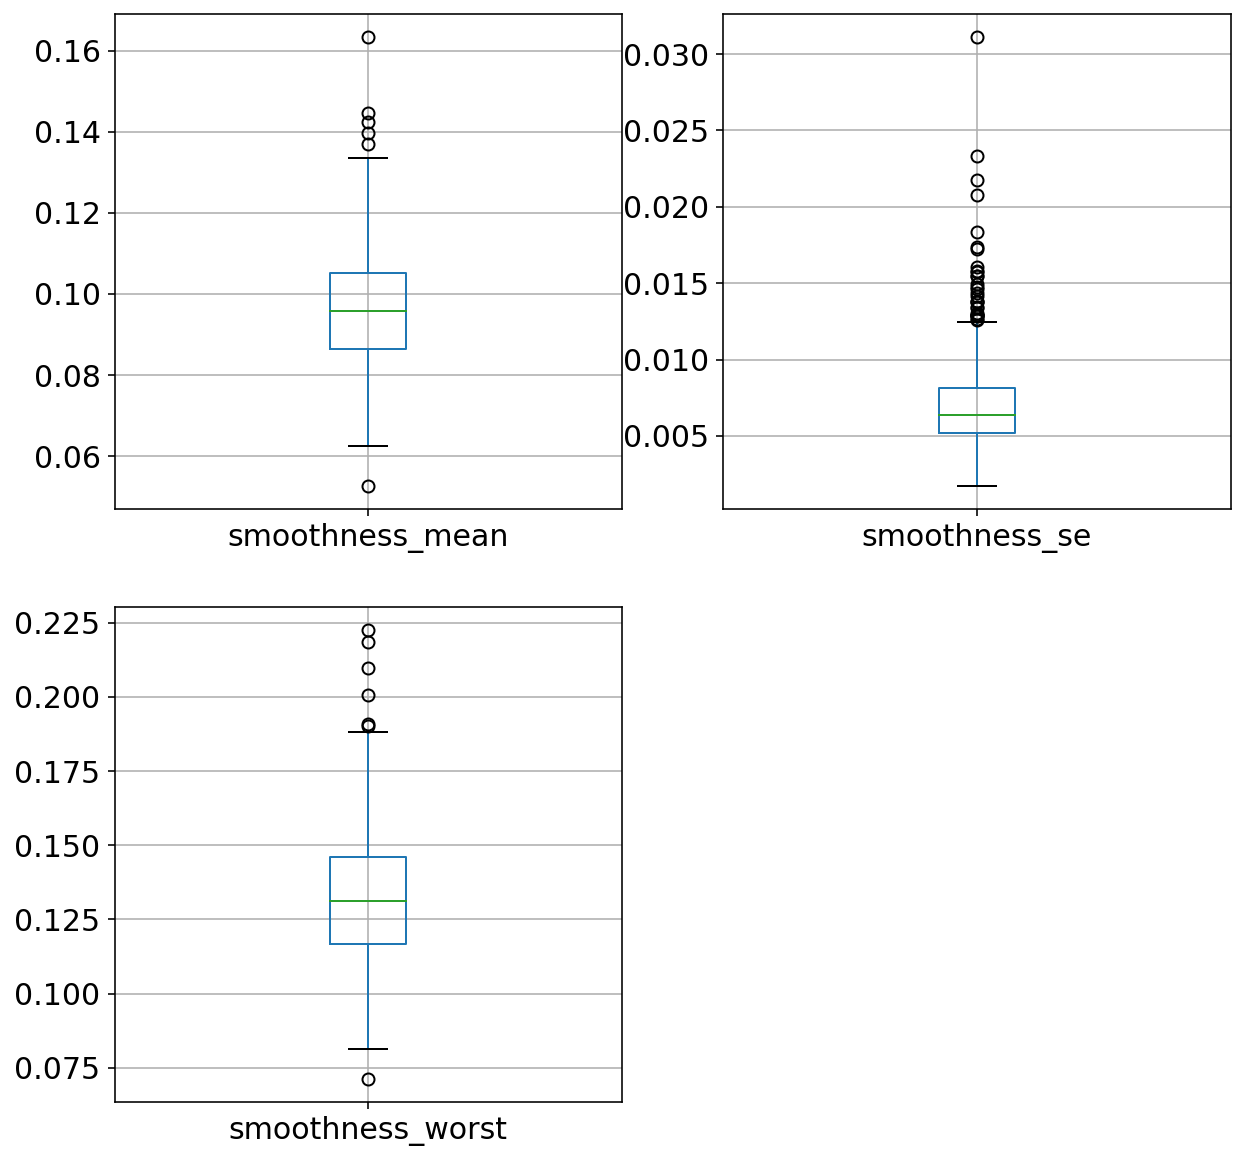

In [95]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('smoothness_mean')
plt.subplot(2,2,2)
df.boxplot('smoothness_se')
plt.subplot(2,2,3)
df.boxplot('smoothness_worst')

#### Compactness

<AxesSubplot:>

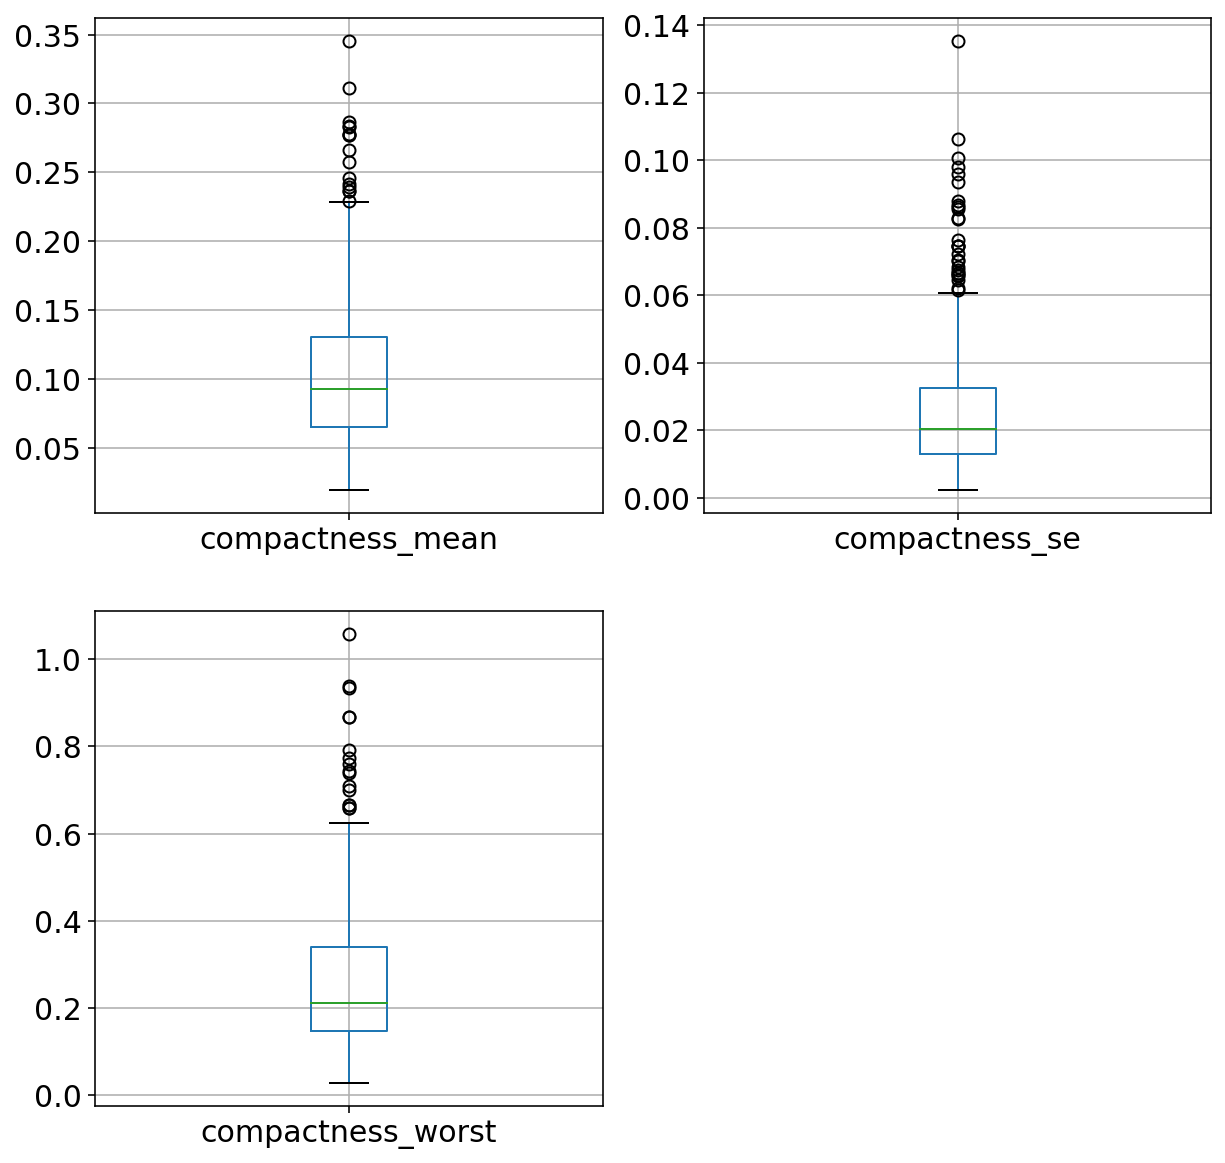

In [96]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('compactness_mean')
plt.subplot(2,2,2)
df.boxplot('compactness_se')
plt.subplot(2,2,3)
df.boxplot('compactness_worst')

#### Concavity

<AxesSubplot:>

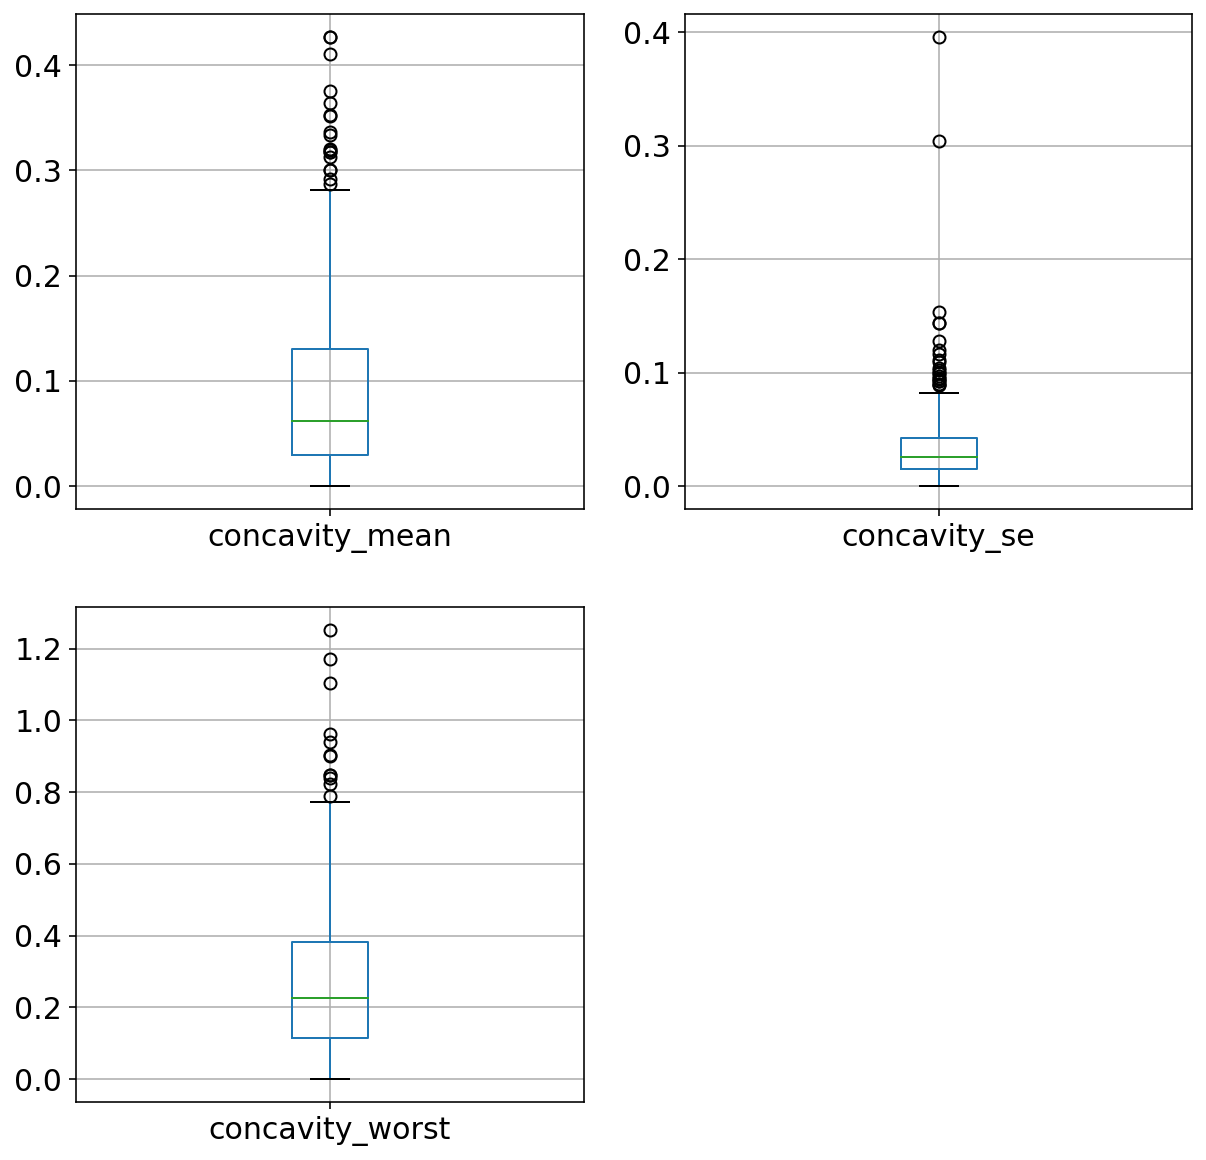

In [97]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('concavity_mean')
plt.subplot(2,2,2)
df.boxplot('concavity_se')
plt.subplot(2,2,3)
df.boxplot('concavity_worst')

#### Concave points

<AxesSubplot:>

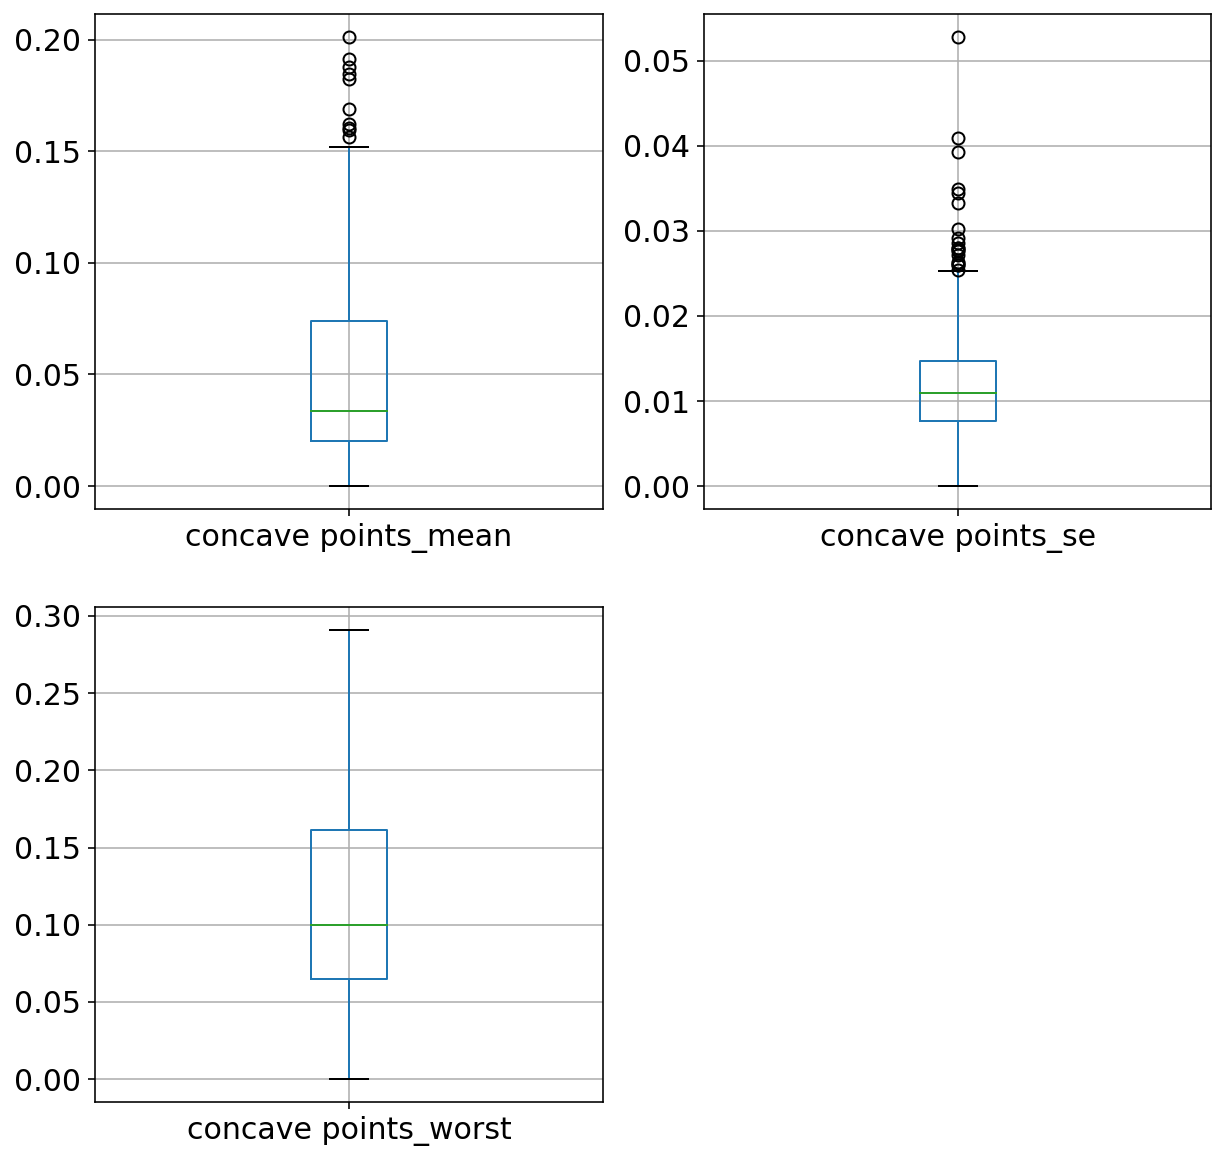

In [98]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('concave points_mean')
plt.subplot(2,2,2)
df.boxplot('concave points_se')
plt.subplot(2,2,3)
df.boxplot('concave points_worst')

#### Symmetry

<AxesSubplot:>

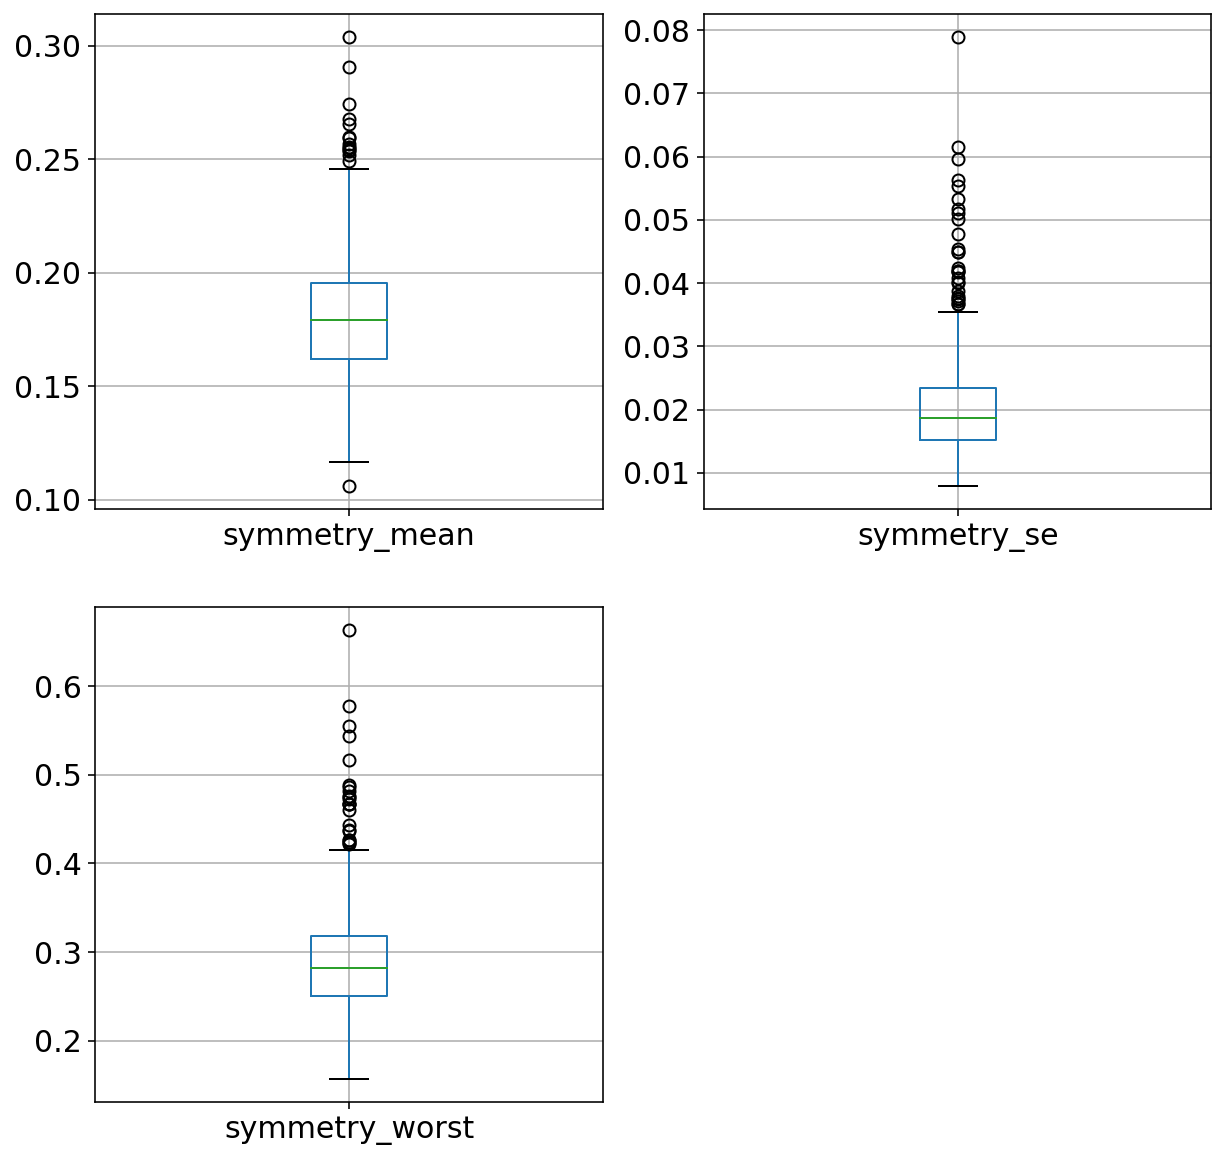

In [99]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('symmetry_mean')
plt.subplot(2,2,2)
df.boxplot('symmetry_se')
plt.subplot(2,2,3)
df.boxplot('symmetry_worst')

#### Fractal dimension

<AxesSubplot:>

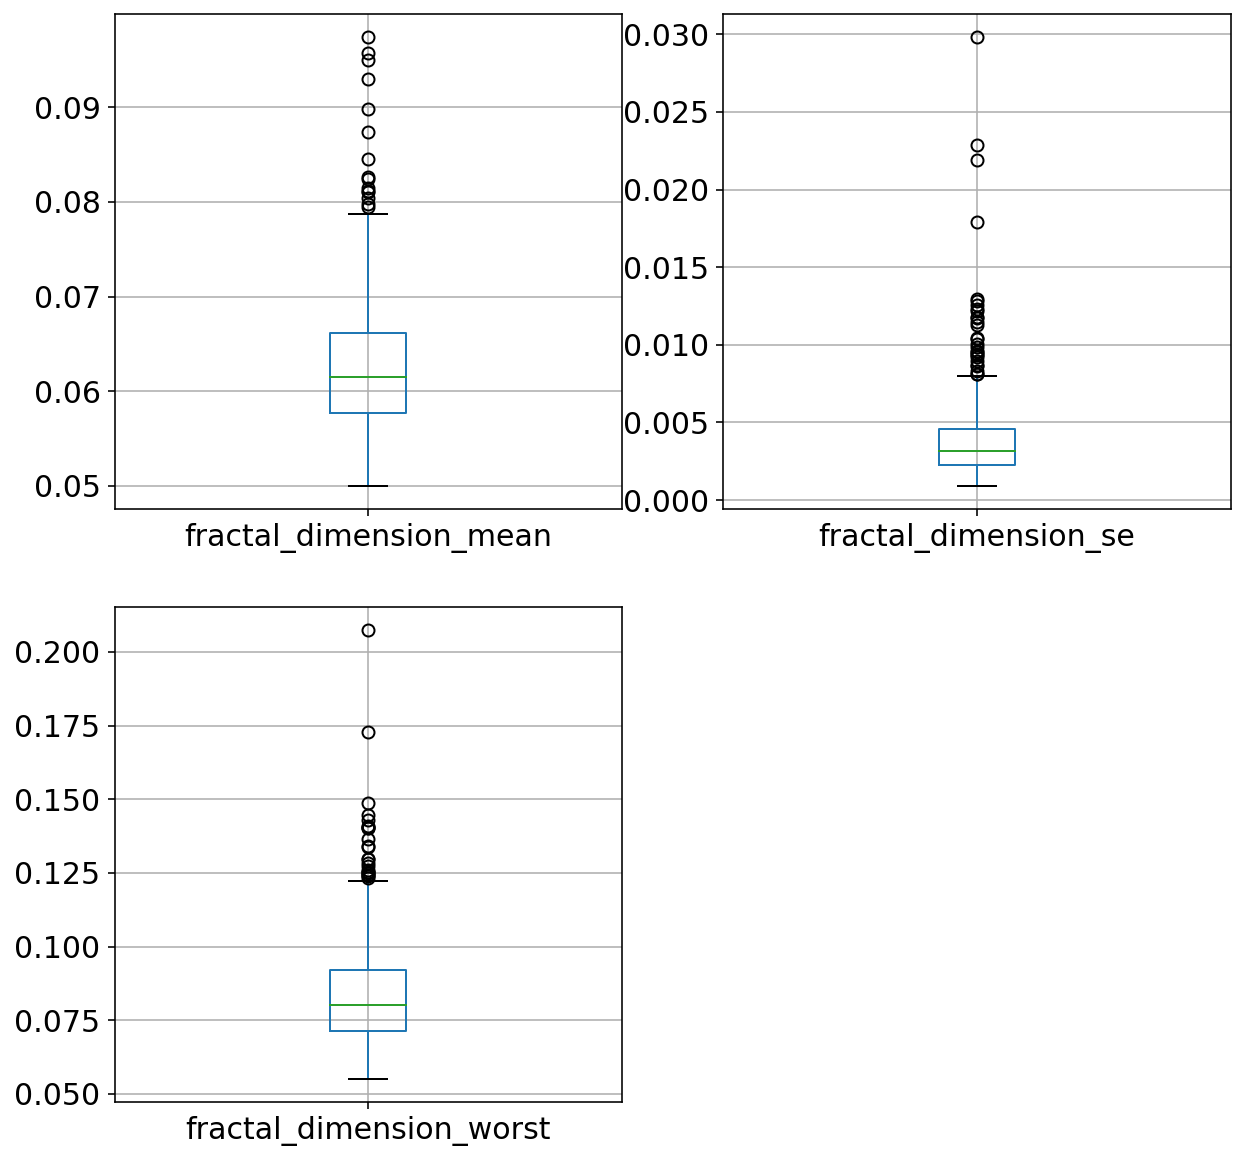

In [100]:
plt.figure(2,figsize=(10,10))
plt.subplot(2,2,1)
df.boxplot('fractal_dimension_mean')
plt.subplot(2,2,2)
df.boxplot('fractal_dimension_se')
plt.subplot(2,2,3)
df.boxplot('fractal_dimension_worst')

### Preprocess your data according to the data quality plan

In [47]:
# Normalize numerical features to range 0 and 1 如果需要的话


In [48]:
# Check how many 0s and 1s are there in the dataset
print('Class 1:', df['diagnosis'].value_counts()[1])
print('Class 0:', df['diagnosis'].value_counts()[0])

Class 1: 357
Class 0: 212


We do not need to do sub_sample since the quantity of target feature is balanced.

## Buliding models

In [49]:
y = df.diagnosis
X = df.drop('diagnosis', axis=1)
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [50]:
train_sizes = [1, 20, 50, 100, 200, 450]
features = X.columns.tolist()
target = ['diagnosis']

### Random Forest

#### Train and evaluate your model

In [51]:
# train model
rfc = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

# predict on test set
rfc_pred = rfc.predict(X_test)

# Evaluation
print('accuracy score: ', accuracy_score(y_test, rfc_pred))
print('f1-score: ', f1_score(y_test, rfc_pred))
print('recall score: ', recall_score(y_test, rfc_pred))
print("confusion_matrix:\n",
              confusion_matrix(y_test, rfc_pred))

accuracy score:  0.951048951048951
f1-score:  0.9590643274853802
recall score:  0.9534883720930233
confusion_matrix:
 [[54  3]
 [ 4 82]]


#### Calculate the variance and bias

In [73]:
# Get the bias and variance
var = np.var(rfc_pred)
n = len(rfc_pred)
SSE = sum(rfc_pred-np.mean(rfc_pred))**2
MSE = SSE / n
Bias = abs((MSE-var))**(1/2)
print("Variance: ", var)
print("Bias: ", Bias)

Variance:  0.24108758374492645
Bias:  0.49100670437879607


#### Plot the learning curve and analyze it

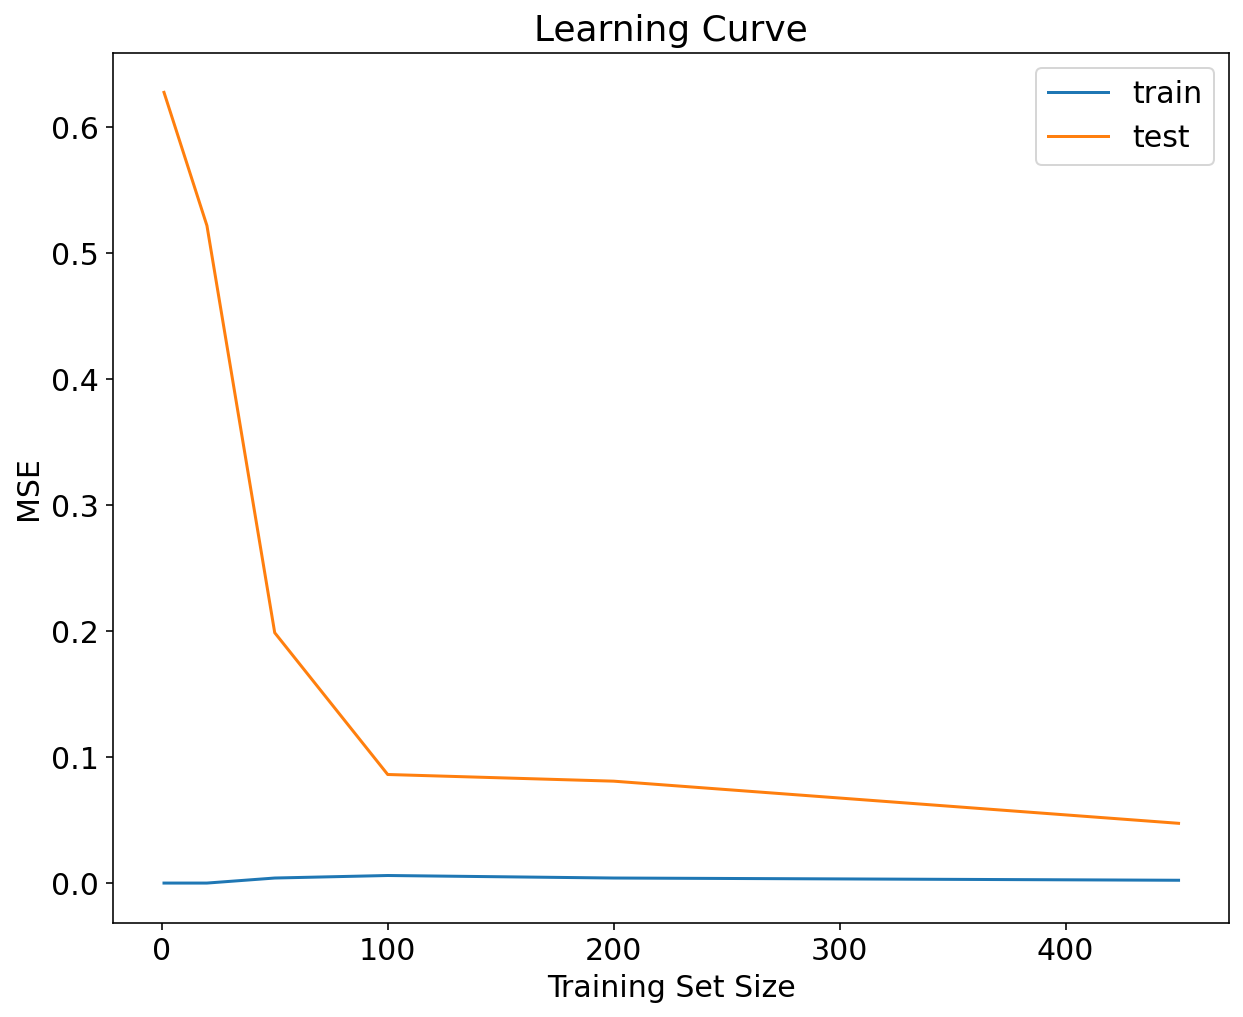

In [53]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator = rfc, X = X, y = y,
    train_sizes = train_sizes,
    scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
test_scores_mean = -test_scores.mean(axis = 1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_scores_mean, label="train")
plt.plot(train_sizes, test_scores_mean, label="test")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.legend(loc="best")

plt.show()

<b>Analysis:</b>

分析learning curve

### AdaBoost

In [54]:
# Train model
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)

# Fit model
abc_model = abc.fit(X_train, y_train)

# Predict on test set
abc_pred = abc_model.predict(X_test)

# Evaluation
print("Accuracy:",metrics.accuracy_score(y_test, abc_pred))
print("recall_score: ", recall_score(y_test, abc_pred))
print("f1_score: ", f1_score(y_test, abc_pred))
print("confusion_matrix:\n",
              confusion_matrix(y_test, abc_pred))

Accuracy: 0.965034965034965
recall_score:  0.9767441860465116
f1_score:  0.9710982658959537
confusion_matrix:
 [[54  3]
 [ 2 84]]


#### Calculate the variance and bias

In [74]:

# Get the bias and variance
var = np.var(abc_pred)
n = len(abc_pred)
SSE = sum(abc_pred-np.mean(abc_pred))**2
MSE = SSE / n
Bias = abs((MSE-var))**(1/2)
print("Variance: ", var)
print("Bias: ", Bias)

Variance:  0.23825125923028023
Bias:  0.4881098843808433


#### Plot the learning curve and analyze it

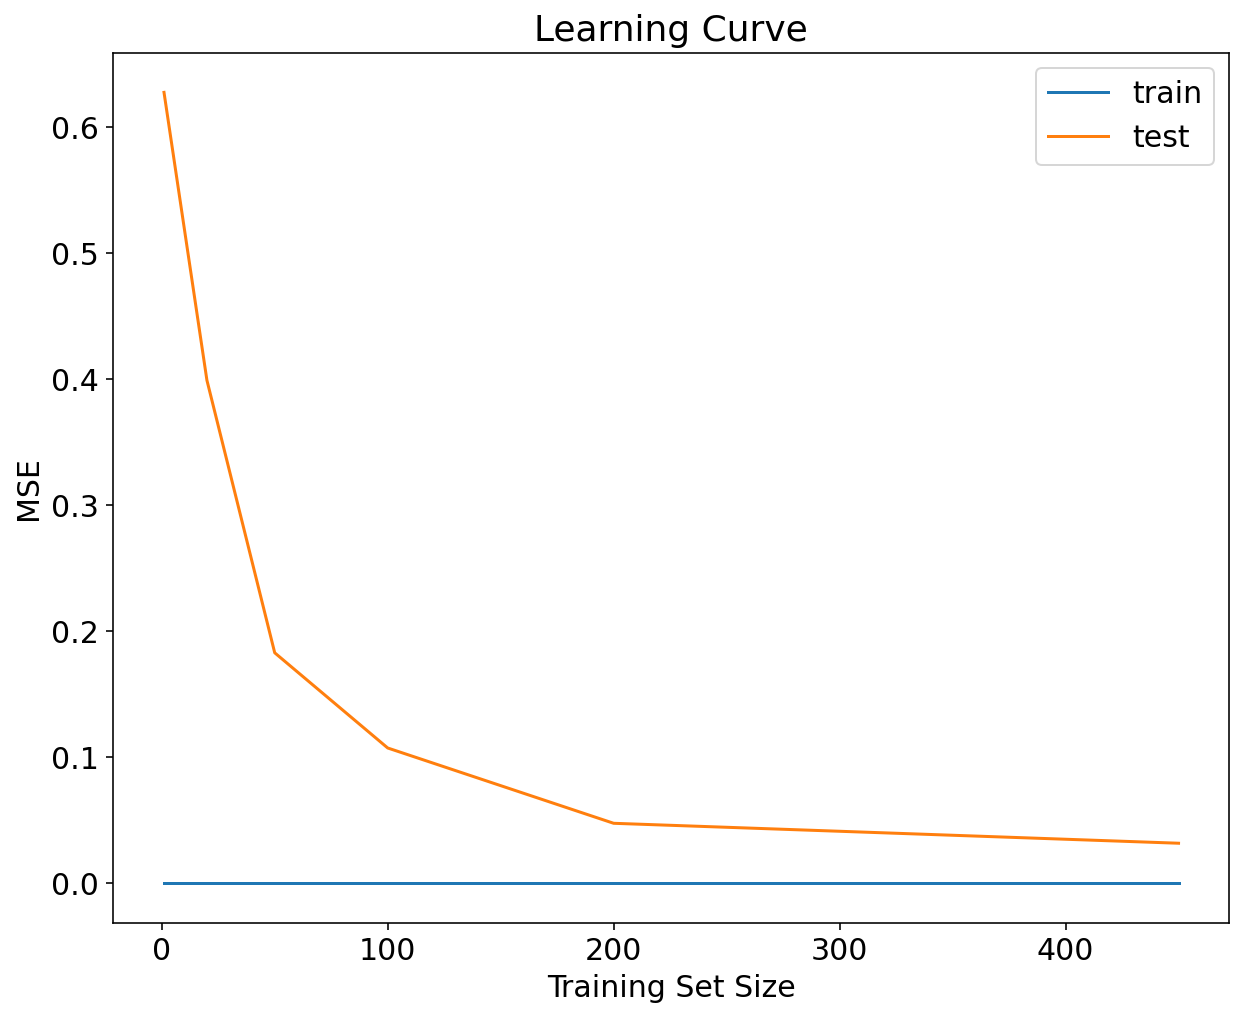

In [56]:
train_sizes, train_scores, test_scores = learning_curve(
    estimator = abc, X = X, y = y,
    train_sizes = train_sizes,
    scoring = 'neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis = 1)
test_scores_mean = -test_scores.mean(axis = 1)

plt.subplots(figsize=(10,8))
plt.plot(train_sizes, train_scores_mean, label="train")
plt.plot(train_sizes, test_scores_mean, label="test")

plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("MSE")
plt.legend(loc="best")

plt.show()

<b>Analysis:</b>
 
 分析learning curve

## Model comparison

### Analyze the bias and variance of the models

## References:
[3]. https://www.analyticsvidhya.com/blog/2021/06/adaboost-a-brief-introduction-to-ensemble-learning/#:~:text=Coming%20to%20the%20advantages%2C%20Adaboost,rather%20than%20binary%20classification%20problems

